<a href="https://colab.research.google.com/github/skhazaei/test/blob/master/complete_diabetes_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
id = '1ExjM-usGlSbW2HUexdEFkhfwebr4243-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('diabetic_data.csv')

In [5]:
data = pd.read_csv('diabetic_data.csv')

In [6]:
data.shape

(101766, 50)

2. Dealing with Duplicate Records : We found out that, for some patient there are number of entries in the dataset these duplicate entries are not helpful in solving the task hence we removed these entries.

In [7]:
print('Total data = ', len(data))
print('Unique entries = ', len(np.unique(data['patient_nbr'])))
unique_patients = data.drop_duplicates(['patient_nbr'], keep = 'first')
unique_patients.shape

Total data =  101766
Unique entries =  71518


(71518, 50)

In [8]:
#data.dropna(inplace = True)
#print('Total data = ', len(data))
#print('Unique entries = ', len(np.unique(data['patient_nbr'])))
data.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
#print('Length after removing Duplicates:', len(data))

In [9]:
data.shape

(71518, 50)

4. Dealing with Missing Values : Missing values in this dataset are represented by ‘?’. Only very few of the columns have missing values. These are, ‘race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3'

In [10]:
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in data.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+--------------------------+----------------+-----------------------+
|       Column Name        | Missing Values |   Missing Percentage  |
+--------------------------+----------------+-----------------------+
|       encounter_id       |       0        |          0.0          |
|       patient_nbr        |       0        |          0.0          |
|           race           |      1948      |  0.027237898151514305 |
|          gender          |       0        |          0.0          |
|           age            |       0        |          0.0          |
|          weight          |     68665      |   0.960107944853044   |
|    admission_type_id     |       0        |          0.0          |
| discharge_disposition_id |       0        |          0.0          |
|   admission_source_id    |       0        |          0.0          |
|     time_in_hospital     |       0        |          0.0          |
|        payer_code        |     31043      |   0.434058558684527   |
|    medical_special

In [11]:
columns_with_missed_values = data[['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']]

In [12]:
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in columns_with_missed_values.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+-------------------+----------------+-----------------------+
|    Column Name    | Missing Values |   Missing Percentage  |
+-------------------+----------------+-----------------------+
|        race       |      1948      |  0.027237898151514305 |
|       weight      |     68665      |   0.960107944853044   |
|     payer_code    |     31043      |   0.434058558684527   |
| medical_specialty |     34477      |   0.4820744427976174  |
|       diag_1      |       11       | 0.0001538074330937666 |
|       diag_2      |      294       | 0.0041108532117788525 |
|       diag_3      |      1225      |  0.017128555049078554 |
+-------------------+----------------+-----------------------+


Drop columns that are missing too much data

In [13]:
data = data.drop(['weight', 'payer_code'], axis=1)

Remove null values Drop the rows where at least one element is missing.

In [14]:
data.dropna(inplace = True)
print('Total data = ', len(data))


Total data =  71518


In [15]:
data.shape

(71518, 48)

In [16]:
columns_with_missed_values = data[['race', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']]

In [17]:
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in columns_with_missed_values.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+-------------------+----------------+-----------------------+
|    Column Name    | Missing Values |   Missing Percentage  |
+-------------------+----------------+-----------------------+
|        race       |      1948      |  0.027237898151514305 |
| medical_specialty |     34477      |   0.4820744427976174  |
|       diag_1      |       11       | 0.0001538074330937666 |
|       diag_2      |      294       | 0.0041108532117788525 |
|       diag_3      |      1225      |  0.017128555049078554 |
+-------------------+----------------+-----------------------+


In [18]:
print(data.shape)
print('% data retained out of unique patients: ' + str(round(len(data.index)/71518 * 100,2)) + '%')
print('% data retained out of all encounters: ' + str(round(len(data.index)/101766 * 100,2)) + '%')
print(data.columns)

(71518, 48)
% data retained out of unique patients: 100.0%
% data retained out of all encounters: 70.28%
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtyp

Drop other columns without relevant information

In [19]:
data = data.drop(['encounter_id', 'patient_nbr'], axis=1)
data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [20]:
data.shape

(71518, 46)

1. Age Feature : The values of age are given like [0–10),[10–20),[20–30) The age feature is not categorical but ordinal and hence we should convert it to numbers and treat it as numeric feature. We are converting age feature to numeric feature like below, [0–10) → 5, [10–20) → 15, [20–30) — -> 25

In [21]:
replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : replaceDict[x])
print(data['age'].head())

0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64


6.2) Using domain knowledge on diag_1, diag_2, diag_3 : The diag_1 , diag_2 , diag_3 are categorical features but these features have lots unique values if we apply one hot encoding directly it will results in lots of features that will eventually invoke “curse of dimensionality” problem We will use the domain knowledge provided in the description file to create fewer categories.

Circulatory → 390–459, 785 → Diseases of the circulatory system
Respiratory → 460–519, 786 → Diseases of the respiratory system
Digestive → 520–579, 787 → Diseases of the digestive system
Diabetes → 250.xx → Diabetes mellitus
Injury → 800–999 → Injury and poisoning
Musculoskeletal → 710–739 → Diseases of the musculoskeletal system and connective tissue
Genitourinary → 580–629, 788 → Diseases of the genitourinary system
Neoplasms → 140–239 → Neoplasms
Pregnecy → 630–679 → Complications of pregnancy, childbirth, and the puerperium
Other
We added Pregnancy as one category original description file kept it in ‘Other’ category but from research we found that Pregnancy creates unique type of diabetes and hence it make sense to keep it as separate category.

In [22]:
print("number of entries for diag_1= ", len((data['diag_1'])))  
print("number of unique entries for diag_1= ", len(np.unique(data['diag_1'])))  
print("number of entries for diag_2= ", len((data['diag_2'])))  
print("number of unique entries for diag_2= ", len(np.unique(data['diag_2'])))  
print("number of entries for diag_3= ", len((data['diag_3'])))  
print("number of entries for diag_3= ", len(np.unique(data['diag_3'])))

number of entries for diag_1=  71518
number of unique entries for diag_1=  697
number of entries for diag_2=  71518
number of unique entries for diag_2=  726
number of entries for diag_3=  71518
number of entries for diag_3=  759


In [23]:
columns_with_missed_values = data[['diag_1', 'diag_2', 'diag_3']]
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in columns_with_missed_values.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+-------------+----------------+-----------------------+
| Column Name | Missing Values |   Missing Percentage  |
+-------------+----------------+-----------------------+
|    diag_1   |       11       | 0.0001538074330937666 |
|    diag_2   |      294       | 0.0041108532117788525 |
|    diag_3   |      1225      |  0.017128555049078554 |
+-------------+----------------+-----------------------+


In [24]:
diag_1 = Counter(list(data['diag_1'])).most_common(1)[0][0]
diag_2 = Counter(list(data['diag_2'])).most_common(1)[0][0]
diag_3 = Counter(list(data['diag_3'])).most_common(1)[0][0]
data['diag_1'] = data['diag_1'].apply(lambda x : diag_1 if x == '?' else x)
data['diag_2'] = data['diag_2'].apply(lambda x : diag_2 if x == '?' else x)
data['diag_3'] = data['diag_3'].apply(lambda x : diag_3 if x == '?' else x)

In [25]:
columns_with_missed_values = data[['diag_1', 'diag_2', 'diag_3']]
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in columns_with_missed_values.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+-------------+----------------+--------------------+
| Column Name | Missing Values | Missing Percentage |
+-------------+----------------+--------------------+
|    diag_1   |       0        |        0.0         |
|    diag_2   |       0        |        0.0         |
|    diag_3   |       0        |        0.0         |
+-------------+----------------+--------------------+


The diag_1 , diag_2 , diag_3 are categorical features but they have lots unique values if we apply one hot encoding directely it will results in lots of feature values that will eventually invoke "curse of dimensionality" problem We will use the domain knowledge provided in the description of data to create fewer values.

In [26]:
# Replace diagnoses with category names
#Circulatory: 390-459, 785
#Respiratory: 460-519, 786
#Digestive: 520-579, 787
#Diabetes: 250.xx
#Injury: 800-999
#Musculoskeletal: 710-739
#Genitourinary: 580-629, 788
#Neoplasms: 140-239, 
#Other: 
#780, 781, 784, 790-799, 240-279 except 250, 680-709, 782, 001-139, 290-319
#E-V (beginning with a letter), 280-289, 320-359, 630-679, 360-389, 740-759

def categorize_diagnosis(diag):
    if diag.isnumeric():
        diag = int(diag)
        if diag in range(390,460) or diag==785:
            return 'Circulatory'
        elif diag in range(460,520) or diag==786:
            return 'Respiratory'
        elif diag in range(520,580) or diag==787:
            return 'Digestive'
        elif diag in np.arange(250,260,0.01):
            return 'Diabetes'
        elif diag in range(800,1000):
            return 'Injury'
        elif diag in range(710,740):
            return  'Musculoskeletal'
        elif diag in range(580,630) or diag==788:
            return  'Genitourinary'
        elif diag in range(140,240):
            return  'Neoplasms'
        else:
            return 'Other'
    else:
        if "250" in diag:
            return 'Diabetes'
        else:
            return  'Other'

In [27]:
data['diag_1_desc'] = data.apply(lambda row: categorize_diagnosis(row['diag_1']), axis=1)
data['diag_2_desc'] = data.apply(lambda row: categorize_diagnosis(row['diag_2']), axis=1)
data['diag_3_desc'] = data.apply(lambda row: categorize_diagnosis(row['diag_3']), axis=1)

# Remove original diagnosis features
data.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)
data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_desc', 'diag_2_desc', 'diag_3_desc'],
      dtype='object')

In [28]:
data.shape

(71518, 46)

In [29]:
print("number of entries for diag_1= ", len((data['diag_1_desc'])))  
print("number of unique entries for diag_1= ", len(np.unique(data['diag_1_desc'])))  
print(data['diag_1_desc'].value_counts())     

number of entries for diag_1=  71518
number of unique entries for diag_1=  9
Circulatory        21905
Other              12347
Respiratory         9776
Digestive           6570
Diabetes            5805
Injury              4779
Musculoskeletal     4080
Genitourinary       3514
Neoplasms           2742
Name: diag_1_desc, dtype: int64


In [30]:
print("number of entries for diag_2= ", len((data['diag_2_desc'])))  
print("number of unique entries for diag_2= ", len(np.unique(data['diag_2_desc'])))  
print(data['diag_2_desc'].value_counts())     

number of entries for diag_2=  71518
number of unique entries for diag_2=  9
Circulatory        22534
Other              18409
Diabetes           10053
Respiratory         7242
Genitourinary       5468
Digestive           2907
Injury              1858
Neoplasms           1750
Musculoskeletal     1297
Name: diag_2_desc, dtype: int64


In [31]:
print("number of entries for diag_3= ", len((data['diag_3_desc'])))  
print("number of unique entries for diag_3= ", len(np.unique(data['diag_3_desc'])))  
print(data['diag_3_desc'].value_counts())     

number of entries for diag_3=  71518
number of unique entries for diag_3=  9
Circulatory        21313
Other              20419
Diabetes           13885
Respiratory         4873
Genitourinary       4199
Digestive           2746
Injury              1443
Musculoskeletal     1378
Neoplasms           1262
Name: diag_3_desc, dtype: int64


3- Drop encounters that resulted in discharge due to hospice or patient death Discharge Disposition ID corresponding to [11 or 13 or 14 or 19 or 20 or 21] indicates patient has expired so there is no chance that it will readmit again so we will remove these records.

Discharge Disposition ID has lots of distinct values using domain knowledge we will convert them into small number of categories.

ddi_cat1 = [6, 8, 9, 13] ddi_cat2 = [3, 4, 5, 14, 22, 23, 24] ddi_cat10 = [12, 15, 16, 17] ddi_cat11 = [19, 20, 21] ddi_cat18 = [25, 26]

In [32]:
print("number of entries for discharge_disposition_id= ", len((data['discharge_disposition_id'])))  
print("number of unique entries for discharge_disposition_id= ", len(np.unique(data['discharge_disposition_id'])))
print(data['discharge_disposition_id'].value_counts())     

number of entries for discharge_disposition_id=  71518
number of unique entries for discharge_disposition_id=  26
1     44317
3      8784
6      8289
18     2474
2      1539
22     1410
11     1077
5       913
25      778
4       541
7       409
23      260
13      243
14      218
28       90
8        73
15       40
24       25
9         9
17        8
10        6
19        6
27        3
16        3
12        2
20        1
Name: discharge_disposition_id, dtype: int64


In [33]:
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

data = data[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [34]:
print("number of entries for discharge_disposition_id= ", len((data['discharge_disposition_id'])))  
print("number of unique entries for discharge_disposition_id= ", len(np.unique(data['discharge_disposition_id'])))  
print(data['discharge_disposition_id'].value_counts())     

number of entries for discharge_disposition_id=  70434
number of unique entries for discharge_disposition_id=  7
1     52931
2     13690
18     3252
7       409
28       90
10       59
27        3
Name: discharge_disposition_id, dtype: int64


Admission Type ID :

Similarly Admission Type ID can be converted into small number of categories ati_cat1 = [2, 7] ati_cat5 = [6, 8]

In [35]:
print("number of entries for admission_type_id= ", len((data['admission_type_id'])))  
print("number of unique entries for admission_type_id= ", len(np.unique(data['admission_type_id'])))
print(data['admission_type_id'].value_counts())     

number of entries for admission_type_id=  70434
number of unique entries for admission_type_id=  8
1    35768
3    13835
2    12861
6     4530
5     3122
8      291
7       18
4        9
Name: admission_type_id, dtype: int64


In [36]:
data['admission_type_id'] = data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

In [37]:
print("number of entries for admission_type_id= ", len((data['admission_type_id'])))  
print("number of unique entries for admission_type_id= ", len(np.unique(data['admission_type_id'])))  
print(data['admission_type_id'].value_counts())   

number of entries for admission_type_id=  70434
number of unique entries for admission_type_id=  4
1    48647
3    13835
5     7943
4        9
Name: admission_type_id, dtype: int64


Admission Source ID :

Similarly Admission Source ID can be converted into small number of categories asi_cat1 = [2, 3] ati_cat4 = [5, 6, 10, 22, 25] ati_cat9 = [15, 17, 20, 21] ati_cat11 = [13, 17]

In [38]:
print("number of entries for admission_source_id= ", len((data['admission_source_id'])))  
print("number of unique entries for admission_source_id= ", len(np.unique(data['admission_source_id']))) 
print(data['admission_source_id'].value_counts())   

number of entries for admission_source_id=  70434
number of unique entries for admission_source_id=  17
7     37563
1     21849
17     4858
4      2541
6      1788
2       909
5       514
20      153
3       136
9        95
8        11
10        7
22        4
14        2
25        2
11        1
13        1
Name: admission_source_id, dtype: int64


In [39]:
data['admission_source_id'] = data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

In [40]:
print("number of entries for admission_source_id= ", len((data['admission_source_id'])))  
print("number of unique entries for admission_source_id= ", len(np.unique(data['admission_source_id'])))  
print(data['admission_source_id'].value_counts())   

number of entries for admission_source_id=  70434
number of unique entries for admission_source_id=  6
7     37563
1     22894
9      5106
4      4856
8        11
11        4
Name: admission_source_id, dtype: int64


In [41]:
id2 = '1P9utjV8bW_-2jlJjLXpF-h_HqiyOhPUz'
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('discharge.csv')

In [42]:
discharge = pd.read_csv("discharge.csv")

In [43]:
id3 = '1CWdb1VPP3PNQIoPKbK0yHxXTygCpvj1l'
downloaded = drive.CreateFile({'id':id3}) 
downloaded.GetContentFile('admission_type.csv')

In [44]:
admission_type = pd.read_csv("admission_type.csv")


In [45]:
admission_type

,admission_type_id,description
0,0,ignore
1,1,Emergency
2,2,Urgent
3,3,Elective
4,4,Newborn
5,5,Not Available
6,6,NaN
7,7,Trauma Center
8,8,Not Mapped


In [46]:
id4 = '1yA37H6wjJwmlKiJfRTWHGBlXXRJ3VpY_'
download = drive.CreateFile({'id': id4})
download.GetContentFile("admission_source.csv")

In [47]:
admission_source = pd.read_csv("admission_source.csv")

Add Three Columns of for IDs Mapping

In [48]:
data['admission_type'] = data['admission_type_id'].map(admission_type['description'])

In [49]:
data[['admission_type', 'admission_type_id']]


,admission_type,admission_type_id
0,Not Available,5
1,Emergency,1
2,Emergency,1
3,Emergency,1
4,Emergency,1
...,...,...
101754,Emergency,1
101755,Emergency,1
101756,Emergency,1
101758,Emergency,1


In [50]:
data['admission_source'] = data['admission_source_id'].map(admission_source['description'])


In [51]:
data[['admission_source', 'admission_source_id']]

,admission_source,admission_source_id
0,Physician Referral,1
1,Emergency Room,7
2,Emergency Room,7
3,Emergency Room,7
4,Emergency Room,7
...,...,...
101754,Emergency Room,7
101755,Emergency Room,7
101756,Emergency Room,7
101758,Emergency Room,7


In [52]:
data['discharge_disposition'] = data['discharge_disposition_id'].map(discharge['description'])

In [53]:
data['discharge_disposition']

0                        NaN
1         Discharged to home
2         Discharged to home
3         Discharged to home
4         Discharged to home
                 ...        
101754    Discharged to home
101755    Discharged to home
101756    Discharged to home
101758    Discharged to home
101765    Discharged to home
Name: discharge_disposition, Length: 70434, dtype: object

In [54]:
data['discharge_disposition'].value_counts()

Discharged to home                                                                         52931
Discharged/transferred to another short term hospital                                      13690
Left AMA                                                                                     409
Discharged/transferred to a federal health care facility.                                     90
Neonate discharged to another hospital for neonatal aftercare                                 59
Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere        3
Name: discharge_disposition, dtype: int64

In [55]:
data.shape

(70434, 49)

lets analyse each and every feature one by one : lets remove them

In [56]:
print("number of entries for gender= ", len((data['gender'])))  
print("number of unique entries for gender= ", len(np.unique(data['gender'])))
print(data['gender'].value_counts())

number of entries for gender=  70434
number of unique entries for gender=  3
Female             37468
Male               32963
Unknown/Invalid        3
Name: gender, dtype: int64


In [57]:
data.drop(data[data.gender == 'Unknown/Invalid'].index, inplace = True)

In [58]:
print("number of entries for gender= ", len((data['gender'])))  
print("number of unique entries for gender= ", len(np.unique(data['gender'])))
print(data['gender'].value_counts())

number of entries for gender=  70431
number of unique entries for gender=  2
Female    37468
Male      32963
Name: gender, dtype: int64


In [59]:
data.shape

(70431, 49)

Glucose Serum test : A blood glucose test is used to find out if your blood sugar levels are in the healthy range. It is often used to help diagnose and monitor diabetes.

'>200' : 200 = indicates diabetes '>300' : 300 = Indicates diabetes 'Norm' : 100 = Normal 'None' : 0 = test was not taken

In [60]:
print("number of entries for max_glu_serum= ", len((data['max_glu_serum'])))  
print("number of unique entries for max_glu_serum= ", len(np.unique(data['max_glu_serum'])))
print(data['max_glu_serum'].value_counts())  

number of entries for max_glu_serum=  70431
number of unique entries for max_glu_serum=  4
None    67046
Norm     1717
>200      946
>300      722
Name: max_glu_serum, dtype: int64


In [61]:
data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

In [62]:
print("number of entries for max_glu_serum= ", len((data['max_glu_serum'])))  
print("number of unique entries for max_glu_serum= ", len(np.unique(data['max_glu_serum'])))  
print(data['max_glu_serum'].value_counts())  

number of entries for max_glu_serum=  70431
number of unique entries for max_glu_serum=  4
0      67046
100     1717
200      946
300      722
Name: max_glu_serum, dtype: int64


A1C test : An A1C test is a blood test that reflects your average blood glucose levels over the past 3 months

'>7' : 7 '>8' : 8 Norm : 5 = Normal None : 0 = Test was not taken

In [63]:
print("number of entries for A1Cresult= ", len((data['A1Cresult'])))  
print("number of unique entries for A1Cresult= ", len(np.unique(data['A1Cresult'])))
print(data['A1Cresult'].value_counts())  

number of entries for A1Cresult=  70431
number of unique entries for A1Cresult=  4
None    57553
>8       6249
Norm     3757
>7       2872
Name: A1Cresult, dtype: int64


In [64]:
data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

In [65]:
print("number of entries for A1Cresult= ", len((data['A1Cresult'])))  
print("number of unique entries for A1Cresult= ", len(np.unique(data['A1Cresult'])))  
print(data['A1Cresult'].value_counts())

number of entries for A1Cresult=  70431
number of unique entries for A1Cresult=  4
0    57553
8     6249
5     3757
7     2872
Name: A1Cresult, dtype: int64


In [66]:
print("number of entries for change= ", len((data['change'])))  
print("number of unique entries for change= ", len(np.unique(data['change'])))  
print(data['change'].value_counts())

number of entries for change=  70431
number of unique entries for change=  2
No    38769
Ch    31662
Name: change, dtype: int64


In [67]:
data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)

In [68]:
print("number of entries for change= ", len((data['change'])))  
print("number of unique entries for change= ", len(np.unique(data['change'])))  
print(data['change'].value_counts())

number of entries for change=  70431
number of unique entries for change=  2
-1    38769
 1    31662
Name: change, dtype: int64


In [69]:
print("number of entries for diabetesMed= ", len((data['diabetesMed'])))  
print("number of unique entries for diabetesMed= ", len(np.unique(data['diabetesMed'])))  
print(data['diabetesMed'].value_counts())

number of entries for diabetesMed=  70431
number of unique entries for diabetesMed=  2
Yes    53606
No     16825
Name: diabetesMed, dtype: int64


In [70]:
data['diabetesMed'] = data['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)

In [71]:
print("number of entries for diabetesMed= ", len((data['diabetesMed'])))  
print("number of unique entries for diabetesMed= ", len(np.unique(data['diabetesMed'])))  
print(data['diabetesMed'].value_counts())

number of entries for diabetesMed=  70431
number of unique entries for diabetesMed=  2
 1    53606
-1    16825
Name: diabetesMed, dtype: int64


In [72]:
print("number of entries for race= ", len((data['race'])))  
print("number of unique entries for race= ", len(np.unique(data['race'])))  
print(data['race'].value_counts())

number of entries for race=  70431
number of unique entries for race=  6
Caucasian          52663
AfricanAmerican    12692
?                   1919
Hispanic            1506
Other               1160
Asian                491
Name: race, dtype: int64


In [73]:
data['race'] = data['race'].apply(lambda x : np.nan if x == '?' else x)
data["race"].fillna(data["race"].mode()[0], inplace = True)

In [74]:
print("number of entries for race= ", len((data['race'])))  
print("number of unique entries for race= ", len(np.unique(data['race'])))  
print(data['race'].value_counts())

number of entries for race=  70431
number of unique entries for race=  5
Caucasian          54582
AfricanAmerican    12692
Hispanic            1506
Other               1160
Asian                491
Name: race, dtype: int64


In [75]:
columns_with_missed_values = data[['race']]
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in columns_with_missed_values.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+-------------+----------------+--------------------+
| Column Name | Missing Values | Missing Percentage |
+-------------+----------------+--------------------+
|     race    |       0        |        0.0         |
+-------------+----------------+--------------------+


In [76]:
data.shape

(70431, 49)

In [77]:
data.drop(columns=['admission_type_id', 'admission_source_id', 'discharge_disposition_id'], inplace=True)

In [78]:
data.shape

(70431, 46)

6.1) Using Domain knowledge on Medical Speciality Feature :

After research we found that medical_specialty is important feature however it has too many distinct values so when we apply one hot encoding it will unnecessarily create lots of features. To group them into smaller number of categories we used frequency based approach and domain knowledge like all kind of surgeons should be placed under ‘surgeon’ category. We failed to group below medical specialty so we grouped them into ‘ungrouped’ category.

Endocrinology →glands
Gastroenterology →stomach
Gynecology →women reproduction system
Hematology →Blood
Hematology/Oncology →Blood
Hospitalist →one who takes care of admitted patients
Oncology →cancer
Ophthalmology →eye
otolaryngology →ears
nose, and throat
Pulmonology →respiratory
Radiology — diagnosing and treating injuries and diseases using medical imaging (radiology) procedures (exams/tests) such as X-rays

In [79]:
print("number of entries for medical_specialty= ", len((data['medical_specialty'])))  
print("number of unique entries for medical_specialty= ", len(np.unique(data['medical_specialty'])))  
print(data['medical_specialty'].value_counts())

number of entries for medical_specialty=  70431
number of unique entries for medical_specialty=  71
?                                   33935
InternalMedicine                    10707
Family/GeneralPractice               5012
Emergency/Trauma                     4406
Cardiology                           4219
                                    ...  
SportsMedicine                          1
Dermatology                             1
Proctology                              1
Surgery-PlasticwithinHeadandNeck        1
Resident                                1
Name: medical_specialty, Length: 71, dtype: int64


In [80]:
columns_with_missed_values = data[['medical_specialty']]
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in columns_with_missed_values.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+-------------------+----------------+--------------------+
|    Column Name    | Missing Values | Missing Percentage |
+-------------------+----------------+--------------------+
| medical_specialty |     33935      | 0.4818190853459414 |
+-------------------+----------------+--------------------+


In [81]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',\
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', \
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', \
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',\
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']

In [82]:
missing = ['?']

colMedical = []

for val in data['medical_specialty'] :
    if val in pediatrics :
        colMedical.append('pediatrics')
    elif val in psychic :
        colMedical.append('psychic')
    elif val in neurology :
        colMedical.append('neurology')
    elif val in surgery :
        colMedical.append('surgery')
    elif val in high_frequency :
        colMedical.append('high_freq')
    elif val in low_frequency :
        colMedical.append('low_freq')
    elif val in ungrouped :
        colMedical.append('ungrouped')
    elif val in missing :
        colMedical.append('missing')

In [83]:
data['medical_specialty'] = colMedical

In [84]:
print("number of entries for medical_specialty= ", len((data['medical_specialty'])))  
print("number of unique entries for medical_specialty= ", len(np.unique(data['medical_specialty'])))  
print(data['medical_specialty'].value_counts())

number of entries for medical_specialty=  70431
number of unique entries for medical_specialty=  8
missing       33935
high_freq     29264
surgery        3408
ungrouped      1786
psychic         904
neurology       573
pediatrics      460
low_freq        101
Name: medical_specialty, dtype: int64


In [85]:
columns_with_missed_values = data[['medical_specialty']]
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in columns_with_missed_values.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+-------------------+----------------+--------------------+
|    Column Name    | Missing Values | Missing Percentage |
+-------------------+----------------+--------------------+
| medical_specialty |       0        |        0.0         |
+-------------------+----------------+--------------------+


In [86]:
# List categorical and numeric features
categorical_feat = []
numerical_feat = []

for col in data.columns:
    if data[col].dtype == 'object':
        categorical_feat.append(col)
    elif 'id' in col:
        categorical_feat.append(col)
    elif data[col].dtype == 'int64':
        numerical_feat.append(col)

In [87]:
categorical_feat

['race',
 'gender',
 'medical_specialty',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'readmitted',
 'diag_1_desc',
 'diag_2_desc',
 'diag_3_desc',
 'admission_type',
 'admission_source',
 'discharge_disposition']

In [88]:
len(categorical_feat)

33

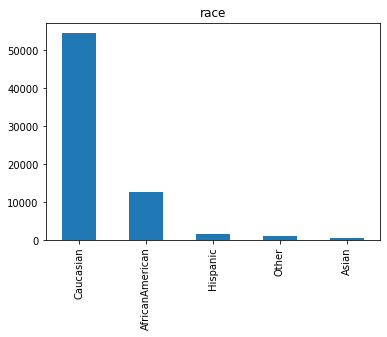

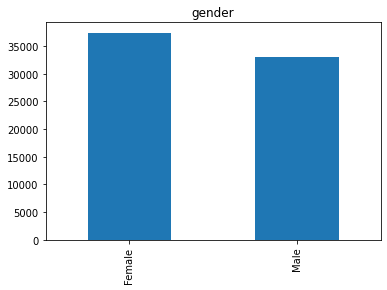

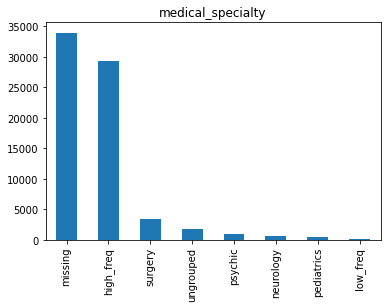

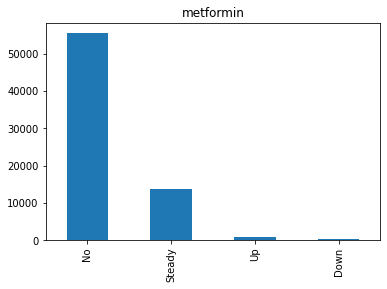

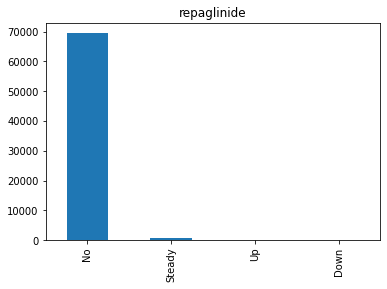

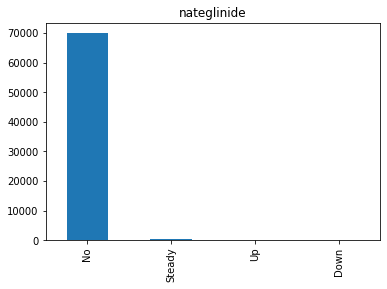

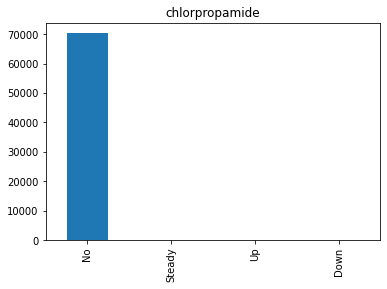

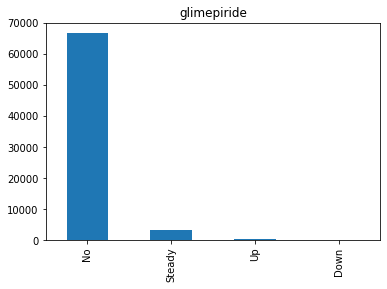

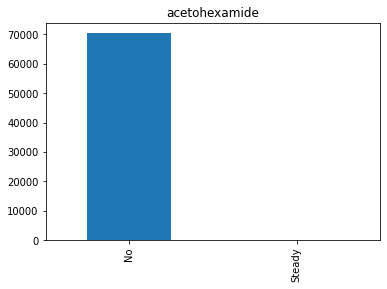

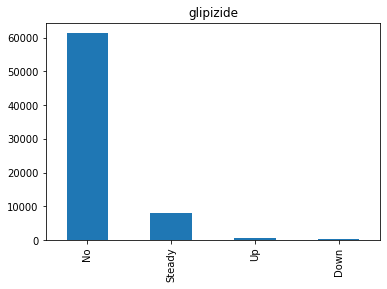

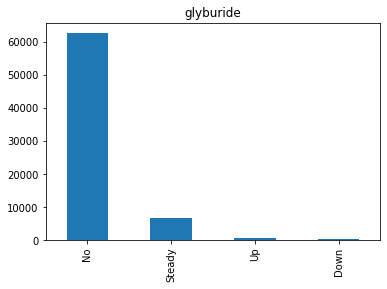

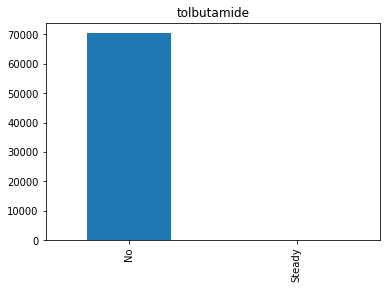

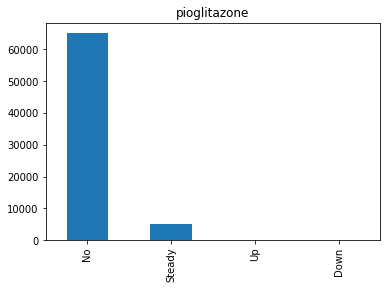

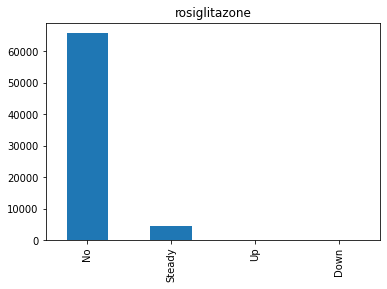

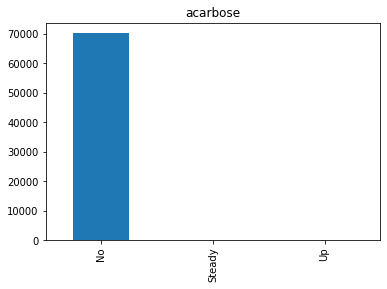

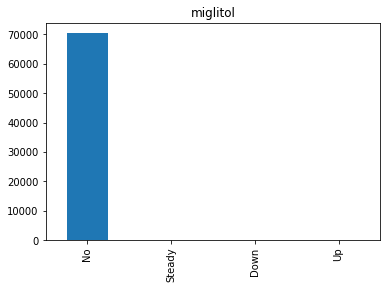

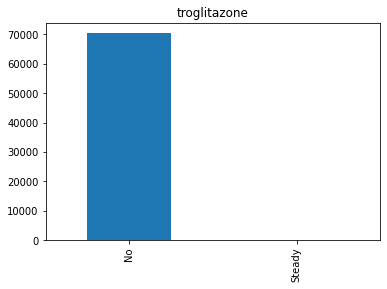

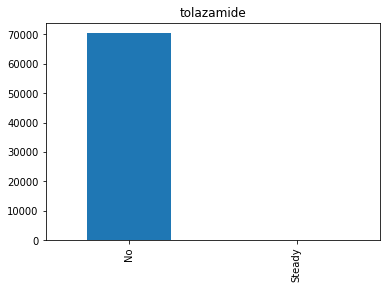

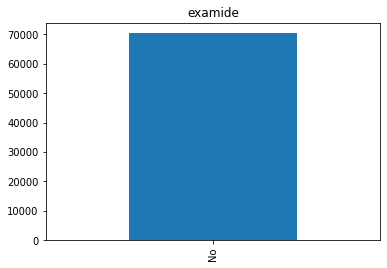

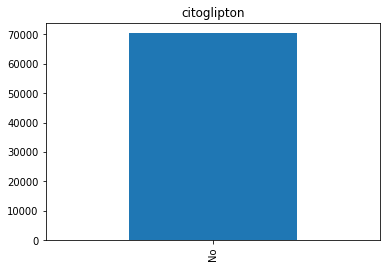

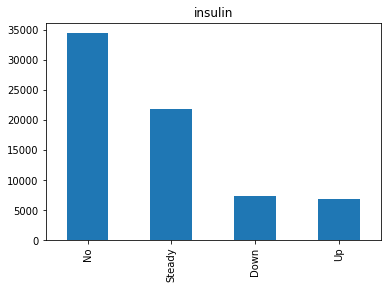

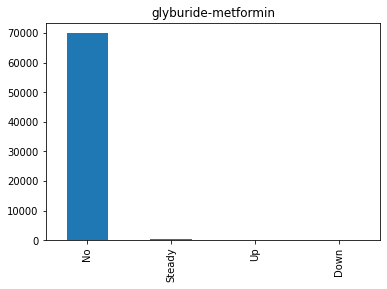

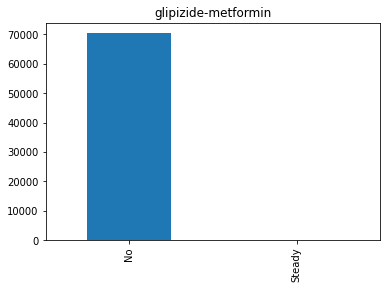

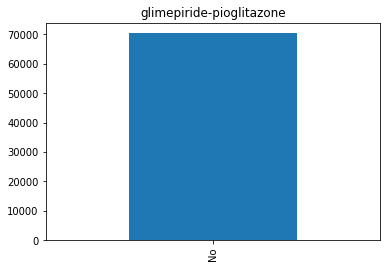

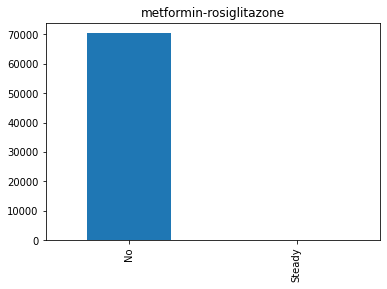

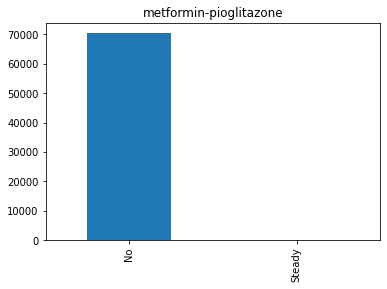

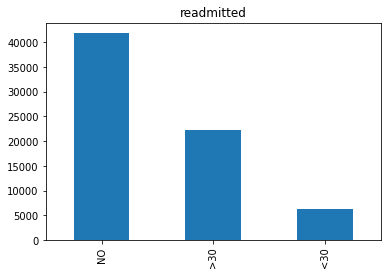

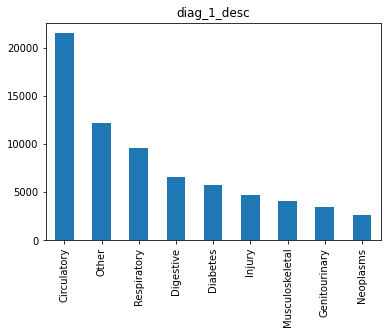

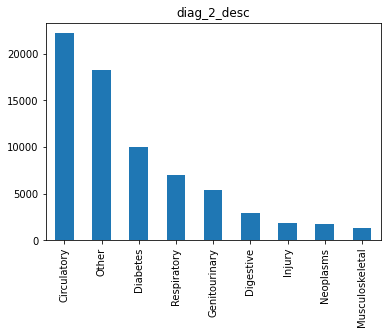

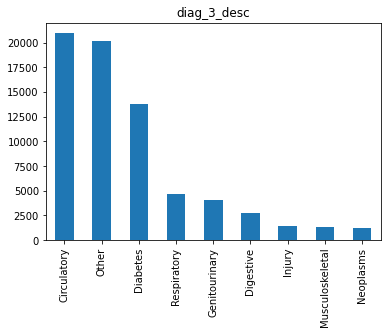

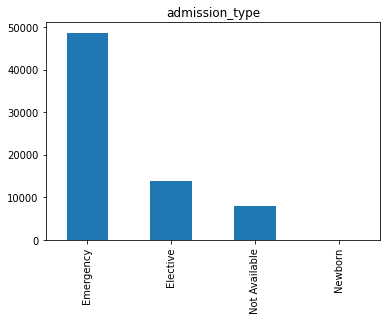

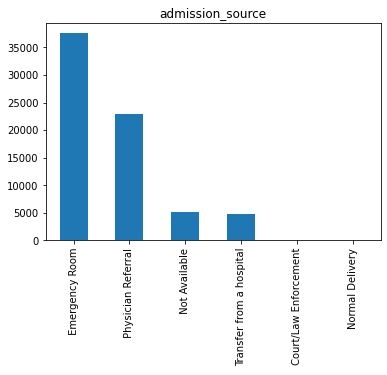

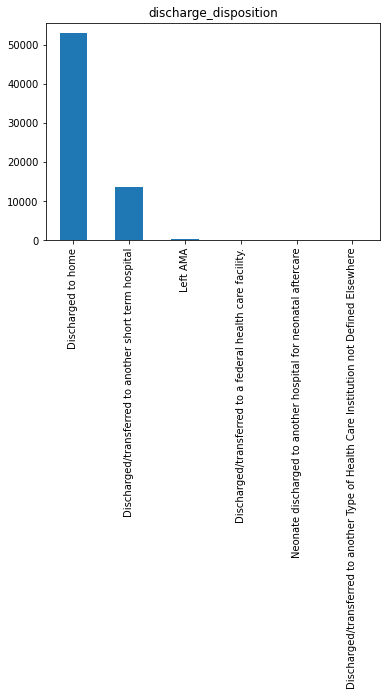

In [89]:
# Bar - categorical
for i in categorical_feat:
    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure(i)
    plt.title(i)
    data[i].value_counts().plot(kind='bar')

# A1C: 83% not tested
# Glucose serum: 95% not testes
# big % not tested but almost 50% changed meds; what diagnoses?
# big % not tested but 77% are prescribed diabetes medications

In [90]:
numerical_feat

['age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'diabetesMed']

In [91]:
len(numerical_feat)

13

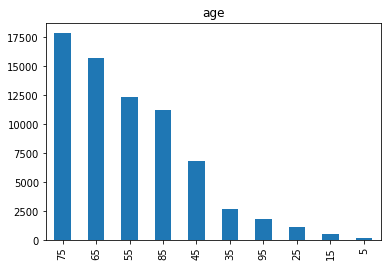

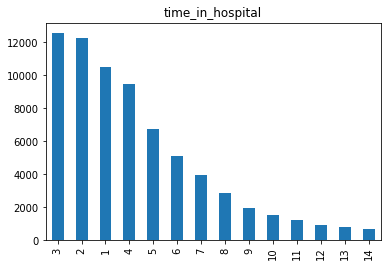

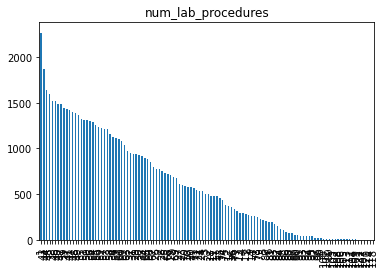

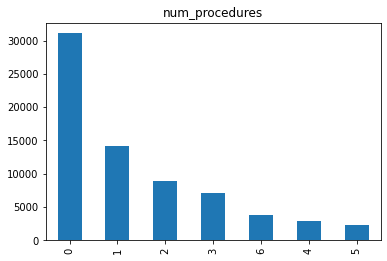

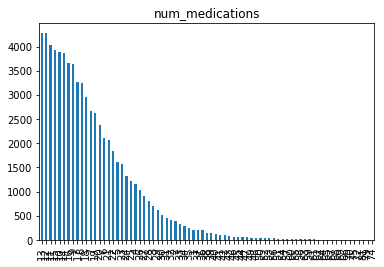

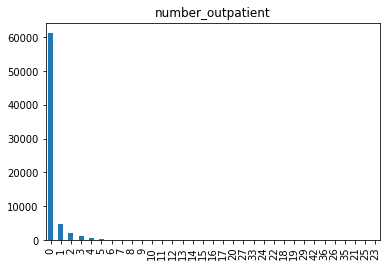

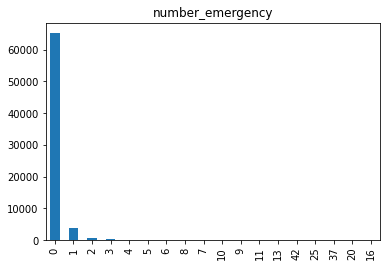

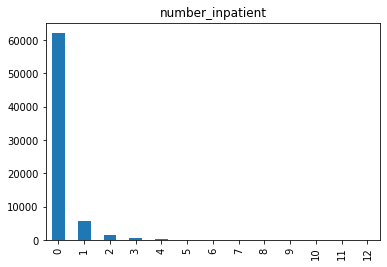

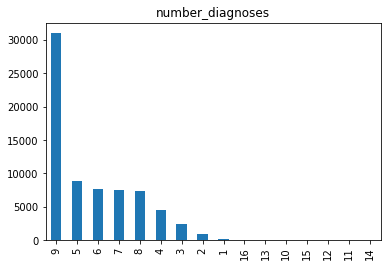

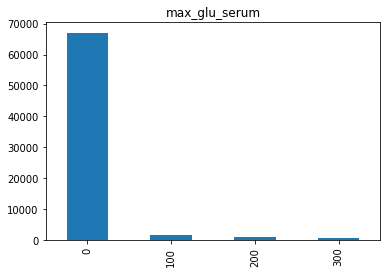

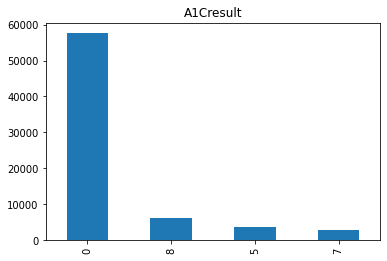

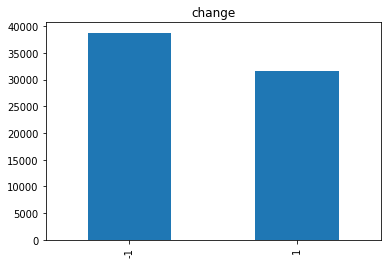

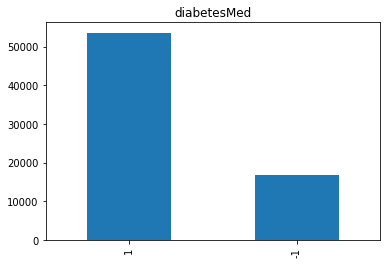

In [92]:
# Bar - categorical
for i in numerical_feat:
    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure(i)
    plt.title(i)
    data[i].value_counts().plot(kind='bar')

# A1C: 83% not tested
# Glucose serum: 95% not testes
# big % not tested but almost 50% changed meds; what diagnoses?
# big % not tested but 77% are prescribed diabetes medications

In [93]:
rejected_features = []
for col in categorical_feat:
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    print(col, rho, pval)
    

print('\n\n')
for col in categorical_feat:
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    if pval < 0.4 : 
        print(col, 'is significant')
    else : 
        print(col, 'is not significant')
        rejected_features.append(col)

rejected_features.remove('discharge_disposition')
print(rejected_features)
## lets remove rejected_features
data.drop(rejected_features, axis = 1, inplace=True)

race -0.0056930216776534285 0.13082735764567194
gender 0.015207461749188637 5.435965568314954e-05
medical_specialty 0.0003131693531934016 0.9337640436064796
metformin 0.022281542689072738 3.3411697625448246e-09
repaglinide -0.021595125497127762 9.945112266553787e-09
nateglinide -0.003605434400493811 0.3386547964799904
chlorpropamide -0.0013294131214496322 0.7242348537760817
glimepiride -0.0007267309783378537 0.8470665993443142
acetohexamide -0.003791400641516911 0.31432923753633707
glipizide -0.020623639175723112 4.405869901071218e-08
glyburide -0.0051329602568039425 0.17313071278812506
tolbutamide 0.0018519647679088576 0.6230858239143404
pioglitazone -0.0111034557191278 0.003211152525857049
rosiglitazone -0.01968313661479235 1.7501424961250147e-07
acarbose -0.00929070562182101 0.013676302823463946
miglitol -0.005250246444981802 0.16351719721882754
troglitazone -0.00262378419144524 0.4862342646322352
tolazamide 0.0036183467842155095 0.33692772504819735
examide nan nan
citoglipton nan n

In [94]:
numerical_feat

['age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'diabetesMed']

In [95]:
len(numerical_feat)

13

In [96]:
rejected_features = []
for col in numerical_feat:
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    print(col, rho, pval)
    

print('\n\n')
for col in numerical_feat:
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    if pval < 0.4 : 
        print(col, 'is significant')
    else : 
        print(col, 'is not significant')
        rejected_features.append(col)

#rejected_features.remove('max_glu_serum')
#rejected_features.remove('A1Cresult')
print(rejected_features)
## lets remove rejected_features
data.drop(rejected_features, axis = 1, inplace=True)

age -0.07429678582673846 8.954111224319551e-87
time_in_hospital -0.07379883754980403 1.2272882383771764e-85
num_lab_procedures -0.05609698877436465 3.347612421210297e-50
num_procedures 0.02478765771921836 4.7282484355105157e-11
num_medications -0.06365929179245991 3.714800263687477e-64
number_outpatient -0.07997419682499037 2.7859885033461646e-100
number_emergency -0.08702137158913922 1.9221892391523947e-118
number_inpatient -0.14978698985912295 0.0
number_diagnoses -0.10244492657140511 1.3016114001998071e-163
max_glu_serum -0.01839692130200671 1.0466641223705332e-06
A1Cresult 0.019212578630065952 3.411361276730968e-07
change -0.03625615041915929 6.273436384129365e-22
diabetesMed -0.061321611132351524 1.1798102813483178e-59



age is significant
time_in_hospital is significant
num_lab_procedures is significant
num_procedures is significant
num_medications is significant
number_outpatient is significant
number_emergency is significant
number_inpatient is significant
number_diagnoses is 

In [97]:
# for numeric variables with 0 values
num_col_z = ['num_procedures','number_outpatient','number_emergency','number_inpatient']

for i in num_col_z:
    print(i + ': ' + str(data[data[i]==0].shape))
    n = data[i].replace(0, np.NaN)
    print(n.describe())
    print('\n')

num_procedures: (31075, 35)
count    39356.000000
mean         2.544898
std          1.629044
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: num_procedures, dtype: float64


number_outpatient: (61243, 35)
count    9188.000000
mean        2.147148
std         2.163680
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        42.000000
Name: number_outpatient, dtype: float64


number_emergency: (65299, 35)
count    5132.000000
mean        1.425370
std         1.304865
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        42.000000
Name: number_emergency, dtype: float64


number_inpatient: (62166, 35)
count    8265.000000
mean        1.507199
std         1.047043
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        12.000000
Name: number_inpatient, dtype: float64




In [98]:
# List categorical and numeric features
categorical_feat = []
numerical_feat = []

for col in data.columns:
    if data[col].dtype == 'object':
        categorical_feat.append(col)
    elif 'id' in col:
        categorical_feat.append(col)
    elif data[col].dtype == 'int64':
        numerical_feat.append(col)

In [99]:
categorical_feat

['race',
 'gender',
 'metformin',
 'repaglinide',
 'nateglinide',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'tolazamide',
 'insulin',
 'metformin-rosiglitazone',
 'readmitted',
 'diag_1_desc',
 'diag_2_desc',
 'diag_3_desc',
 'admission_type',
 'admission_source',
 'discharge_disposition']

In [100]:
len(categorical_feat)

22

In [101]:
numerical_feat

['age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'diabetesMed']

In [102]:
len(numerical_feat)

13

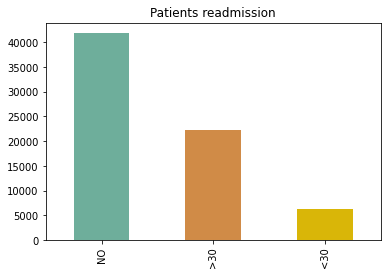

In [103]:
plt.figure()
plt.title('Patients readmission')
data['readmitted'].value_counts().plot(kind='bar',color=['#6EAE9B','#D08B47','#D9B608'])

In [104]:
# % of categ features
for i in categorical_feat:
    a = data.groupby([i]).size().reset_index(name='counts')
    a['pcts'] = round((a['counts']/a['counts'].sum() * 100),2)
    print(a)

              race  counts   pcts
0  AfricanAmerican   12692  18.02
1            Asian     491   0.70
2        Caucasian   54582  77.50
3         Hispanic    1506   2.14
4            Other    1160   1.65
   gender  counts  pcts
0  Female   37468  53.2
1    Male   32963  46.8
  metformin  counts   pcts
0      Down     435   0.62
1        No   55497  78.80
2    Steady   13661  19.40
3        Up     838   1.19
  repaglinide  counts   pcts
0        Down      29   0.04
1          No   69509  98.69
2      Steady     820   1.16
3          Up      73   0.10
  nateglinide  counts   pcts
0        Down       8   0.01
1          No   69938  99.30
2      Steady     469   0.67
3          Up      16   0.02
  acetohexamide  counts   pcts
0            No   70430  100.0
1        Steady       1    0.0
  glipizide  counts   pcts
0      Down     375   0.53
1        No   61382  87.15
2    Steady    8099  11.50
3        Up     575   0.82
  glyburide  counts   pcts
0      Down     419   0.59
1        No   626

In [105]:
# Get counts for each readmitted, diagnosis 1 desc
data_diag_cnt = data.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
data_diag_cnt = data_diag_cnt[data_diag_cnt['readmitted']=='<30']
data_diag_cnt1 = data_diag_cnt['counts'].tolist()

data_diag_cnt = data.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
data_diag_cnt = data_diag_cnt[data_diag_cnt['readmitted']=='>30']
data_diag_cnt2 = data_diag_cnt['counts'].tolist()

data_diag_cnt = data.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
data_diag_cnt = data_diag_cnt[data_diag_cnt['readmitted']=='NO']
data_diag_cnt3 = data_diag_cnt['counts'].tolist()
#df_diag_cnt

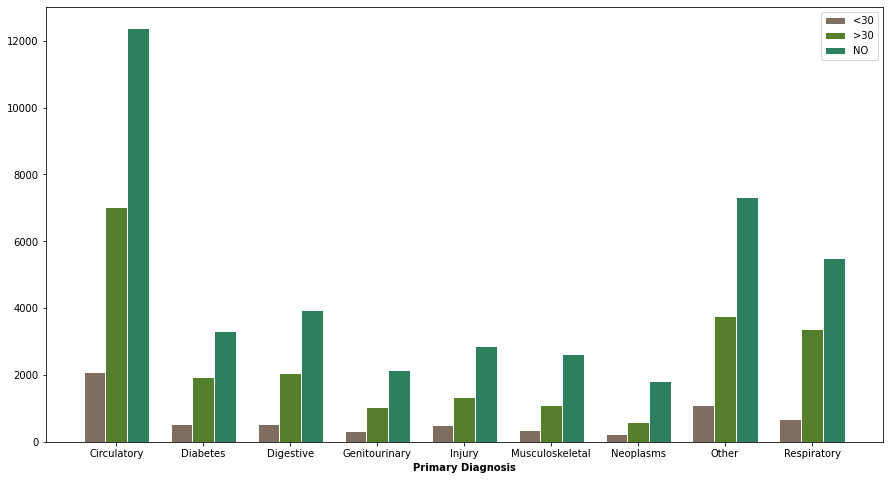

In [106]:
# Plot Readmission vs Primary Diagnosis
data1 = data[['diag_1_desc','readmitted']]
data1

fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = data_diag_cnt1
bars2 = data_diag_cnt2
bars3 = data_diag_cnt3
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='<30')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='>30')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='NO')
 
# Add xticks on the middle of the group bars
plt.xlabel('Primary Diagnosis', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury',
                                                      'Musculoskeletal','Neoplasms','Other','Respiratory'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [107]:
# Number of patients per readmitted ind and primary diagnosis
data_diag_cnt = data.groupby(['readmitted', 'diag_1_desc']).size().reset_index(name='counts')
data_diag_cnt

,readmitted,diag_1_desc,counts
0,<30,Circulatory,2079
1,<30,Diabetes,525
2,<30,Digestive,522
3,<30,Genitourinary,311
4,<30,Injury,506
5,<30,Musculoskeletal,341
6,<30,Neoplasms,231
7,<30,Other,1087
8,<30,Respiratory,691
9,>30,Circulatory,7039


In [108]:
# A1C Results vs Readmitted
data.groupby(['A1Cresult','readmitted']).size().reset_index(name='counts')

,A1Cresult,readmitted,counts
0,0,<30,5213
1,0,>30,18377
2,0,NO,33963
3,5,<30,324
4,5,>30,1041
5,5,NO,2392
6,7,<30,246
7,7,>30,862
8,7,NO,1764
9,8,<30,510


In [109]:
total_a1c_res = data.groupby(['A1Cresult']).size().reset_index(name='counts')
a1c_res_readm_cnt = data.groupby(['readmitted', 'A1Cresult']).size().reset_index(name='counts')

read_a1c = a1c_res_readm_cnt.groupby(['readmitted', 'A1Cresult']).agg({'counts': 'sum'})
read = a1c_res_readm_cnt.groupby(['A1Cresult']).agg({'counts': 'sum'})
a1c_pcts = read_a1c.div(read) * 100
a1c_pcts.rename(columns = {'counts':'pcts'})


pcts
readmitted A1Cresult           
<30        0           9.057738
           5           8.623902
           7           8.565460
           8           8.161306
>30        0          31.930568
           5          27.708278
           7          30.013928
           8          31.365018
NO         0          59.011694
           5          63.667820
           7          61.420613
           8          60.473676

In [110]:
# means
data.groupby(['readmitted']).mean()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed
readmitted,,,,,,,,,,,,,
<30,67.849198,4.797394,44.930240,1.422692,16.620213,0.309868,0.149849,0.370729,7.513745,9.391387,1.179406,-0.053234,0.598602
>30,66.639838,4.419604,43.992986,1.355126,15.892941,0.379406,0.151799,0.257734,7.485791,9.244604,1.210387,-0.057374,0.582374
NO,64.570147,4.134374,42.043487,1.457492,15.403432,0.222922,0.071507,0.104826,7.053702,7.465750,1.301733,-0.131176,0.478830


In [111]:
categorical_feat_mod = ['race',
 'gender',
 'metformin',
 'repaglinide',
 'nateglinide',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'tolazamide',
 'insulin',
 'metformin-rosiglitazone',
 'readmitted',
 'diag_1_desc',
 'diag_2_desc',
 'diag_3_desc',
 'admission_type']

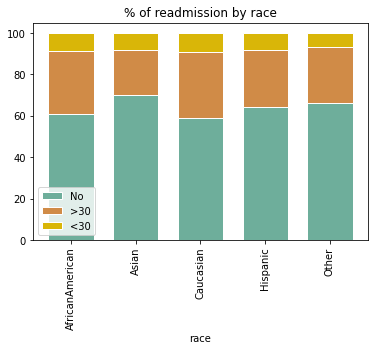

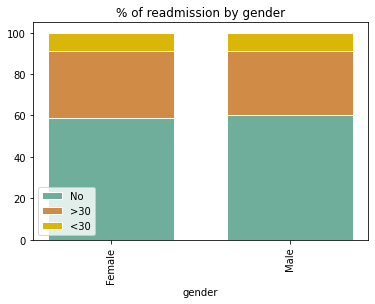

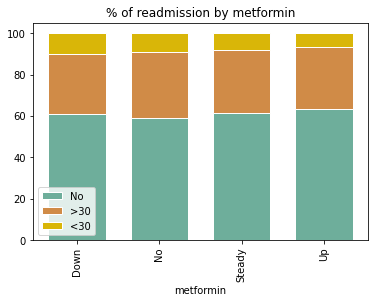

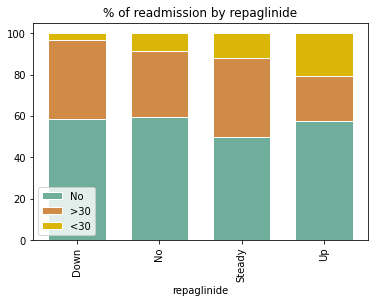

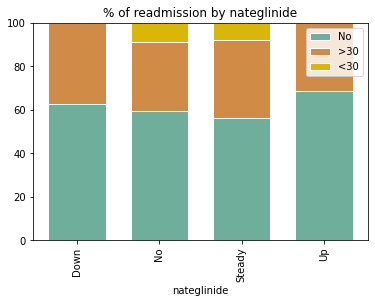

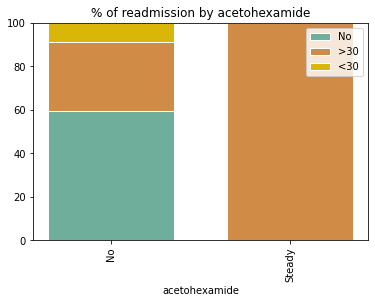

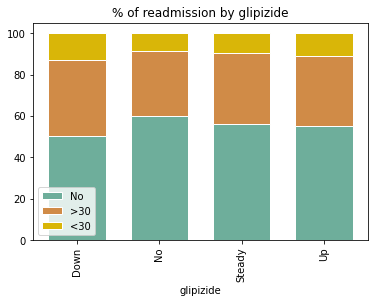

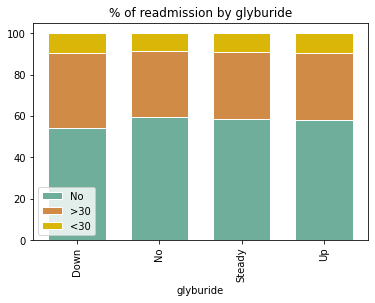

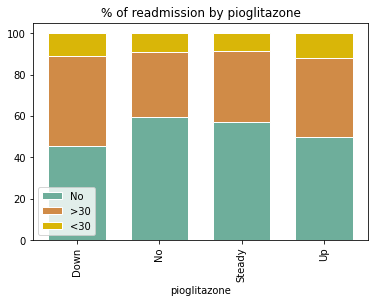

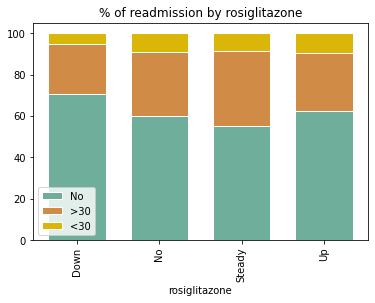

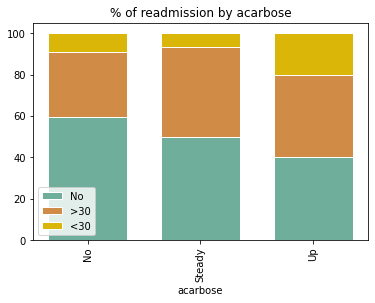

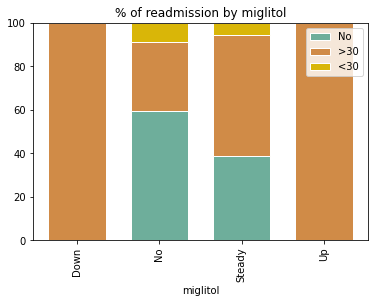

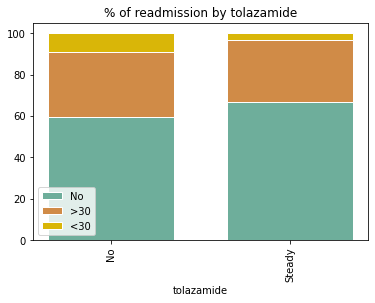

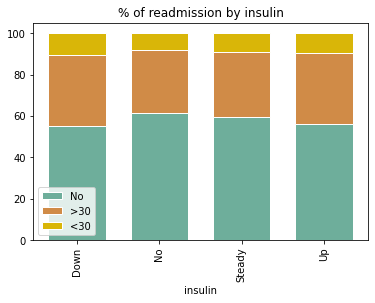

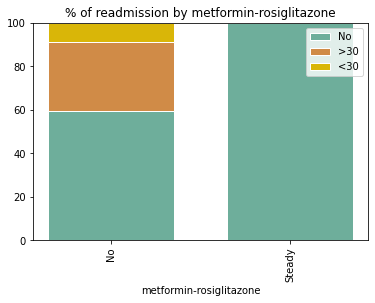

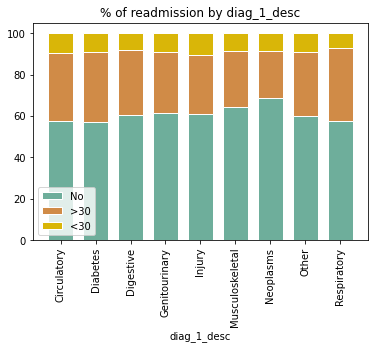

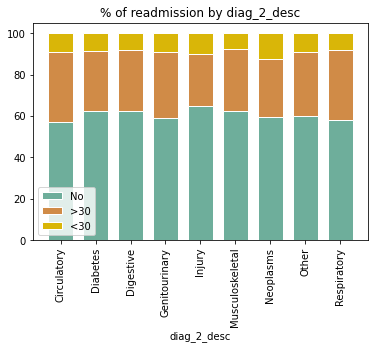

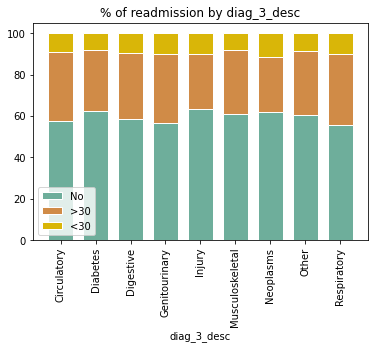

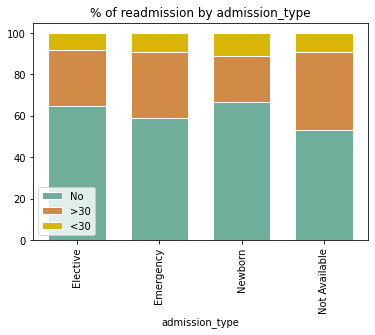

In [112]:
# Loop bar plots to show relationship of readmitted to other categorical variables
for i in categorical_feat_mod:
    if i != 'readmitted':
        readm_cnt = ('readm_cnt_'+ i)
        read = ('read_' + i)
        pcts = ('pcts_' + i)
        unique_val_cnt = len(data[i].unique())  
        
        # Get counts of each value in i grouped by readmitted; show 0 values
        readm_cnt = data.groupby(['readmitted', i]).readmitted.count()
        levels = [readm_cnt.index.levels[0].values, readm_cnt.index.levels[1].values]
        new_index = pd.MultiIndex.from_product(levels, names=readm_cnt.index.names)
        readm_cnt = readm_cnt.reindex(new_index, fill_value=0)
        readm_cnt = readm_cnt.reset_index(name='counts')
        
        # Get percentages
        read = readm_cnt.groupby(['readmitted', i]).agg({'counts': 'sum'})
        read1 = readm_cnt.groupby([i]).agg({'counts': 'sum'})
        pcts = read.div(read1) * 100
        pcts = pcts.rename(columns = {'counts':'pcts'})
        pcts = pcts.reset_index()

        # Plot
        fig,ax = plt.subplots()

        # Values of each group
        bars1 = pcts.loc[pcts.readmitted=='NO','pcts'].tolist()
        bars2 = pcts.loc[pcts.readmitted=='>30','pcts'].tolist()
        bars3 = pcts.loc[pcts.readmitted=='<30','pcts'].tolist()

        bars = np.add(bars1, bars2).tolist()
        r = list(range(len(data[i].unique())))

        names = pcts[i]
        barWidth = 0.7

        plt.bar(r, bars1, color='#6EAE9B', edgecolor='white', width=barWidth)
        plt.bar(r, bars2, bottom=bars1, color='#D08B47', edgecolor='white', width=barWidth)
        plt.bar(r, bars3, bottom=bars, color='#D9B608', edgecolor='white', width=barWidth)

        plt.xticks(r, names, rotation='vertical')
        plt.xlabel(i)

        plt.title('% of readmission by ' + i)
        plt.legend(['No','>30','<30'])
        plt.show()

In [113]:
# Show percentages for each categorical features grouped by readmitted
for i in categorical_feat:
    if i != 'readmitted':
        readm_cnt = ('readm_cnt_'+ i)
        read = ('read_' + i)
        pcts = ('pcts_' + i)
        unique_val_cnt = len(data[i].unique())
        readm_cnt = data.groupby(['readmitted', i]).size().reset_index(name='counts')
        read = readm_cnt.groupby(['readmitted', i]).agg({'counts': 'sum'})
        read1 = readm_cnt.groupby([i]).agg({'counts': 'sum'})
        pcts = read.div(read1) * 100
        pcts = pcts.rename(columns = {'counts':'pcts'})
        print(pcts)

                                 pcts
readmitted race                      
<30        AfricanAmerican   8.611724
           Asian             8.350305
           Caucasian         9.081749
           Hispanic          8.100930
           Other             6.896552
>30        AfricanAmerican  30.491648
           Asian            21.792261
           Caucasian        32.133304
           Hispanic         27.423639
           Other            26.810345
NO         AfricanAmerican  60.896628
           Asian            69.857434
           Caucasian        58.784947
           Hispanic         64.475432
           Other            66.293103
                        pcts
readmitted gender           
<30        Female   8.994342
           Male     8.867518
>30        Female  32.278211
           Male    30.779965
NO         Female  58.727447
           Male    60.352516
                           pcts
readmitted metformin           
<30        Down       10.114943
           No          9.1

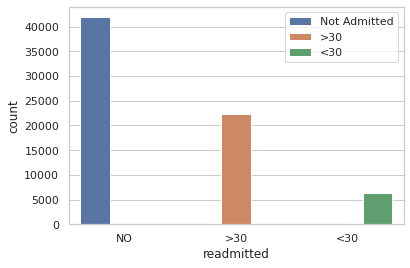

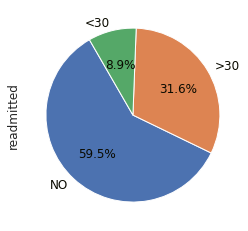

In [114]:
plt.figure()
sns.set_theme(style="whitegrid")
ax = sns.countplot(x = 'readmitted', data = data, hue = 'readmitted')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels = ['Not Admitted', '>30', '<30'])
plt.figure()
data.readmitted.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})

Data Preparation

One-hot encode categorical features Scale numeric features Join categorical, numeric, and target Split into train and test sets

In [115]:
# Reset index
data.reset_index(inplace=True)
data.drop(columns='index')

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,metformin-rosiglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc,admission_type,admission_source,discharge_disposition
0,Caucasian,Female,5,1,41,0,1,0,0,0,...,No,-1,-1,NO,Diabetes,Diabetes,Diabetes,Not Available,Physician Referral,NaN
1,Caucasian,Female,15,3,59,0,18,0,0,0,...,No,1,1,>30,Other,Diabetes,Other,Emergency,Emergency Room,Discharged to home
2,AfricanAmerican,Female,25,2,11,5,13,2,0,1,...,No,-1,1,NO,Other,Diabetes,Other,Emergency,Emergency Room,Discharged to home
3,Caucasian,Male,35,2,44,1,16,0,0,0,...,No,1,1,NO,Other,Diabetes,Circulatory,Emergency,Emergency Room,Discharged to home
4,Caucasian,Male,45,1,51,0,8,0,0,0,...,No,1,1,NO,Neoplasms,Neoplasms,Diabetes,Emergency,Emergency Room,Discharged to home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70426,Caucasian,Female,75,9,50,2,33,0,0,0,...,No,1,1,>30,Digestive,Digestive,Diabetes,Emergency,Emergency Room,Discharged to home
70427,Other,Female,45,14,73,6,26,0,1,0,...,No,1,1,>30,Genitourinary,Genitourinary,Respiratory,Emergency,Emergency Room,Discharged to home
70428,Other,Female,65,2,46,6,17,1,1,1,...,No,-1,1,>30,Injury,Genitourinary,Circulatory,Emergency,Emergency Room,Discharged to home
70429,Caucasian,Female,85,5,76,1,22,0,1,0,...,No,1,1,NO,Other,Other,Other,Emergency,Emergency Room,Discharged to home


1. One-hot encode categorical features

In [116]:
df_categ = data[categorical_feat]
df_categ = df_categ.drop(columns='readmitted')
df_categ.head()

,race,gender,metformin,repaglinide,nateglinide,acetohexamide,glipizide,glyburide,pioglitazone,rosiglitazone,...,miglitol,tolazamide,insulin,metformin-rosiglitazone,diag_1_desc,diag_2_desc,diag_3_desc,admission_type,admission_source,discharge_disposition
0,Caucasian,Female,No,No,No,No,No,No,No,No,...,No,No,No,No,Diabetes,Diabetes,Diabetes,Not Available,Physician Referral,NaN
1,Caucasian,Female,No,No,No,No,No,No,No,No,...,No,No,Up,No,Other,Diabetes,Other,Emergency,Emergency Room,Discharged to home
2,AfricanAmerican,Female,No,No,No,No,Steady,No,No,No,...,No,No,No,No,Other,Diabetes,Other,Emergency,Emergency Room,Discharged to home
3,Caucasian,Male,No,No,No,No,No,No,No,No,...,No,No,Up,No,Other,Diabetes,Circulatory,Emergency,Emergency Room,Discharged to home
4,Caucasian,Male,No,No,No,No,Steady,No,No,No,...,No,No,Steady,No,Neoplasms,Neoplasms,Diabetes,Emergency,Emergency Room,Discharged to home


In [117]:
df_categ.shape

(70431, 21)

In [118]:
categorical_feat.remove('readmitted')
# One-hot encoding
one_hot_df = pd.get_dummies(df_categ, prefix=categorical_feat)
one_hot_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,metformin_Down,metformin_No,metformin_Steady,...,admission_source_ Not Available,admission_source_ Physician Referral,admission_source_Normal Delivery,admission_source_Transfer from a hospital,discharge_disposition_Discharged to home,discharge_disposition_Discharged/transferred to a federal health care facility.,discharge_disposition_Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere,discharge_disposition_Discharged/transferred to another short term hospital,discharge_disposition_Left AMA,discharge_disposition_Neonate discharged to another hospital for neonatal aftercare
0,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70426,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
70427,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
70428,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
70429,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


2. Scale numeric features

In [119]:
df_numer = data[numerical_feat]
df_numer.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed
0,5,1,41,0,1,0,0,0,1,0,0,-1,-1
1,15,3,59,0,18,0,0,0,9,0,0,1,1
2,25,2,11,5,13,2,0,1,6,0,0,-1,1
3,35,2,44,1,16,0,0,0,7,0,0,1,1
4,45,1,51,0,8,0,0,0,5,0,0,1,1


3. Join categorical, numeric, and target

In [121]:
# Join one hot encoded features & numerical features
fin_df = one_hot_df.join(df_numer)
fin_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,metformin_Down,metformin_No,metformin_Steady,...,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed
0,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,-1,-1
1,0,0,1,0,0,1,0,0,1,0,...,0,18,0,0,0,9,0,0,1,1
2,1,0,0,0,0,1,0,0,1,0,...,5,13,2,0,1,6,0,0,-1,1
3,0,0,1,0,0,0,1,0,1,0,...,1,16,0,0,0,7,0,0,1,1
4,0,0,1,0,0,0,1,0,1,0,...,0,8,0,0,0,5,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70426,0,0,1,0,0,1,0,0,1,0,...,2,33,0,0,0,9,0,7,1,1
70427,0,0,0,0,1,1,0,0,1,0,...,6,26,0,1,0,9,0,8,1,1
70428,0,0,0,0,1,1,0,0,1,0,...,6,17,1,1,1,9,0,0,-1,1
70429,0,0,1,0,0,1,0,0,1,0,...,1,22,0,1,0,9,0,0,1,1


In [122]:
# Join target variable - readmitted
target = pd.DataFrame(data['readmitted'])
fin_df = fin_df.join(target)
fin_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,metformin_Down,metformin_No,metformin_Steady,...,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,-1,-1,NO
1,0,0,1,0,0,1,0,0,1,0,...,18,0,0,0,9,0,0,1,1,>30
2,1,0,0,0,0,1,0,0,1,0,...,13,2,0,1,6,0,0,-1,1,NO
3,0,0,1,0,0,0,1,0,1,0,...,16,0,0,0,7,0,0,1,1,NO
4,0,0,1,0,0,0,1,0,1,0,...,8,0,0,0,5,0,0,1,1,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70426,0,0,1,0,0,1,0,0,1,0,...,33,0,0,0,9,0,7,1,1,>30
70427,0,0,0,0,1,1,0,0,1,0,...,26,0,1,0,9,0,8,1,1,>30
70428,0,0,0,0,1,1,0,0,1,0,...,17,1,1,1,9,0,0,-1,1,>30
70429,0,0,1,0,0,1,0,0,1,0,...,22,0,1,0,9,0,0,1,1,NO


In [123]:
fin_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70431 entries, 0 to 70430
Columns: 109 entries, race_AfricanAmerican to readmitted
dtypes: int64(13), object(1), uint8(95)
memory usage: 13.9+ MB


In [124]:
fin_df['readmitted']


0         NO
1        >30
2         NO
3         NO
4         NO
        ... 
70426    >30
70427    >30
70428    >30
70429     NO
70430     NO
Name: readmitted, Length: 70431, dtype: object

In [125]:
fin_df['readmitted'].value_counts()

NO     41898
>30    22240
<30     6293
Name: readmitted, dtype: int64

4. Split into train and test sets

In [126]:
from sklearn.model_selection import train_test_split

X = fin_df.drop(columns='readmitted')
y = fin_df['readmitted']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


**Modeling & Evaluation**

Test on different groupings of target variable:

Predicting 3 classes (<30, >30, No)
Predicting readmission (0: No, 1: <30 + >30)
Predicting early readmission (0: >30 + No, 1: <30)
For each grouping: Resample training set Fit classification models on training set & evaluate on test set Get important features

In [127]:
# Resampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

**Predicting 3 classes: (<30, >30, No) Resample training set**

In [128]:
#Resample & fit model on training set

#Specify how many samples we want for <30 class and >30 class after resampling
over_strategy = {'>30':21000, '<30':10000}
under_strategy = {'NO': 28000}

#Oversample minority classes (<30, >30)
oversample = SMOTENC(categorical_features=range(0,107), sampling_strategy=over_strategy)

#Undersample majority class (No)
undersample = RandomUnderSampler(sampling_strategy=under_strategy)

steps = [('o', oversample), ('u', undersample)]
resampling = Pipeline(steps=steps)

X_train_res, y_train_res = resampling.fit_resample(X_train, y_train)

In [129]:
y_train_res.value_counts()

NO     28000
>30    21000
<30    10000
Name: readmitted, dtype: int64

**Fit classification models on training set & evaluate on test set**

**Logistic regression**

In [130]:
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
X_train_res

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,metformin_Down,metformin_No,metformin_Steady,...,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed
0,1,0,0,0,0,0,1,0,1,0,...,2,18,0,0,1,5,0,0,-1,-1
1,0,0,1,0,0,1,0,0,1,0,...,3,20,0,0,0,5,0,0,1,1
2,1,0,0,0,0,1,0,0,0,0,...,0,17,0,1,0,9,0,0,1,1
3,0,0,1,0,0,0,1,0,1,0,...,0,4,0,0,1,9,0,0,-1,-1
4,0,0,1,0,0,0,1,0,1,0,...,3,24,2,0,0,9,0,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58995,0,0,1,0,0,1,0,0,1,0,...,0,12,0,0,0,9,0,0,-1,1
58996,0,0,1,0,0,0,1,0,1,0,...,0,7,5,0,0,6,0,7,-1,1
58997,0,0,1,0,0,0,1,0,1,0,...,0,17,0,0,0,5,0,0,1,1
58998,1,0,0,0,0,1,0,0,0,1,...,1,27,0,0,0,8,0,5,1,1


In [131]:
from sklearn.metrics import roc_curve, auc
#Fit logistic regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_res, y_train_res)

#Get final evaluation metrics on test set for logistic regression
lr_train_score = lr.score(X_train_res, y_train_res)
lr_test_score = lr.score(X_test, y_test)
print("Logistic regression: ")
print("train mean accuracy: %f" %(lr_train_score))
print("test mean accuracy: %f" %(lr_test_score))

#Get confusion matrix and f1-score
y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train_res.columns)
#Sort coefficients in ascending order
sorted_coeff_index = lr.coef_[0].argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Logistic regression: 
train mean accuracy: 0.550949
test mean accuracy: 0.600483
[[  24  356  888]
 [  32 1372 3016]
 [  61 1275 7063]]
f1-score: 0.554005
Least important features (smallest coefs): 
['diag_1_desc_Respiratory' 'diag_3_desc_Musculoskeletal'
 'diag_2_desc_Genitourinary' 'diag_3_desc_Respiratory'
 'diag_3_desc_Genitourinary' 'diag_2_desc_Respiratory'
 'diag_2_desc_Musculoskeletal' 'diag_1_desc_Neoplasms'
 'diag_1_desc_Genitourinary' 'diag_1_desc_Digestive' 'diag_2_desc_Injury'
 'diag_1_desc_Injury' 'diag_3_desc_Digestive' 'diag_2_desc_Digestive'
 'diag_1_desc_Musculoskeletal' 'diag_1_desc_Other' 'diag_3_desc_Injury'
 'diag_3_desc_Other' 'diag_3_desc_Circulatory' 'diag_3_desc_Neoplasms']

Most important features (largest coefs): 
['miglitol_No' 'metformin-rosiglitazone_No' 'acetohexamide_No'
 'tolazamide_No' 'nateglinide_No'
 'discharge_disposition_Discharged/transferred to a federal health care facility.'
 'discharge_disposition_Neonate discharged to another hospital for n

In [132]:
imp = []
for colName, importance in zip(np.array(X_train.columns), lr.coef_[0]) :
    imp.append((colName, importance))

imp = [(key, val) for key, val in sorted(imp, key = lambda x : x[1], reverse = True)]

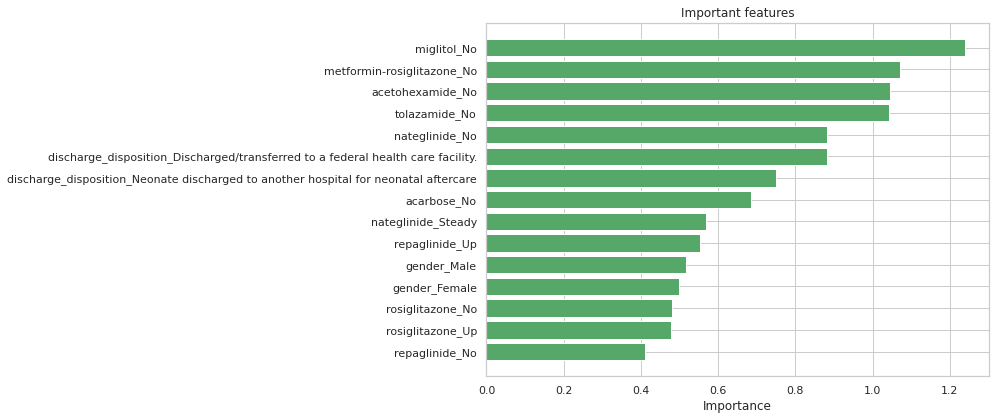

In [133]:
imp1 = imp[0:15]
plt.figure(figsize=(9, 6.5))
plt.barh(range(len(imp1))[::-1], [x[1]  for x in imp1] , align='center', color = 'g')
plt.yticks(range(len(imp1))[::-1], [x[0]  for x in imp1], )
plt.xlabel('Importance')
plt.title('Important features')
plt.show()

**Random Forest**

In [134]:
#Fit random classifier model
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, min_samples_split=5)
rf.fit(X_train_res, y_train_res)


#Get evaluation metrics on test set for random forest
rf_train_score = rf.score(X_train_res, y_train_res)
rf_test_score = rf.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Random forest: 
train mean accuracy: 0.534949
test mean accuracy: 0.607014
[[   4  259 1005]
 [   0 1066 3354]
 [   0  918 7481]]
f1-score: 0.541731
Least important features (smallest coefs): 
['metformin-rosiglitazone_No' 'rosiglitazone_Down' 'acetohexamide_Steady'
 'nateglinide_Down' 'repaglinide_Up' 'miglitol_Up' 'tolazamide_No'
 'repaglinide_Down' 'miglitol_Steady' 'tolazamide_Steady' 'miglitol_No'
 'admission_type_Newborn'
 'discharge_disposition_Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
 'metformin-rosiglitazone_Steady' 'admission_source_Normal Delivery'
 'admission_source_ Court/Law Enforcement' 'miglitol_Down' 'acarbose_Up'
 'nateglinide_Up' 'acetohexamide_No']

Most important features (largest coefs): 
['number_diagnoses' 'age' 'number_inpatient'
 'discharge_disposition_Discharged/transferred to another short term hospital'
 'num_medications' 'num_lab_procedures' 'num_procedures'
 'admission_source_Transfer from a hospital' 'A1Cre

In [135]:
imp = []
for colName, importance in zip(np.array(X_train.columns), rf.feature_importances_) :
    imp.append((colName, importance))

imp = [(key, val) for key, val in sorted(imp, key = lambda x : x[1], reverse = True)]

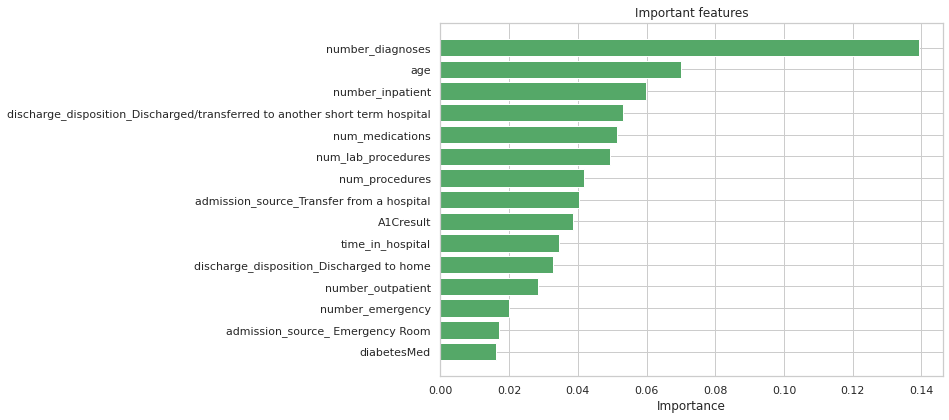

In [136]:
imp1 = imp[0:15]
plt.figure(figsize=(9, 6.5))
plt.barh(range(len(imp1))[::-1], [x[1]  for x in imp1] , align='center', color = 'g')
plt.yticks(range(len(imp1))[::-1], [x[0]  for x in imp1], )
plt.xlabel('Importance')
plt.title('Important features')
plt.show()

**Predicting readmission, two classes (0: No, 1: <30 + >30)**

In [137]:
fin_df.readmitted = fin_df.readmitted.replace('NO', 0)
fin_df.readmitted = fin_df.readmitted.replace('<30', 1)
fin_df.readmitted = fin_df.readmitted.replace('>30', 2)

In [138]:
fin_df['readmitted'].value_counts()

0    41898
2    22240
1     6293
Name: readmitted, dtype: int64

In [139]:
readmitted_df = fin_df.copy(deep=True)
replace_readmitted = lambda x: 1 if x!=0 else 0

readmitted_df['readmitted_or_not'] = readmitted_df.apply(lambda row: replace_readmitted(row['readmitted']), axis=1)
readmitted_df.drop(columns='readmitted', inplace=True)

readmitted_df['readmitted_or_not'].value_counts()


0    41898
1    28533
Name: readmitted_or_not, dtype: int64

In [140]:
X = readmitted_df.drop(columns='readmitted_or_not')
y = readmitted_df['readmitted_or_not']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [141]:
y_train.value_counts()


0    33450
1    22894
Name: readmitted_or_not, dtype: int64

**Fit classification models on training set & evaluate on test set**

**Logistic regression**

In [142]:
#Fit logistic regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

#Get final evaluation metrics on test set for logistic regression
lr_train_score = lr.score(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)
print("Logistic regression: ")
print("train mean accuracy: %f" %(lr_train_score))
print("test mean accuracy: %f" %(lr_test_score))

#Get confusion matrix and f1-score
y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = lr.coef_[0].argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Logistic regression: 
train mean accuracy: 0.625497
test mean accuracy: 0.626464
[[7363 1085]
 [4177 1462]]
f1-score: 0.584810
Least important features (smallest coefs): 
['miglitol_No' 'rosiglitazone_Down' 'acarbose_No' 'diag_1_desc_Neoplasms'
 'admission_source_Transfer from a hospital' 'race_Asian'
 'admission_type_Elective' 'admission_source_ Court/Law Enforcement'
 'acetohexamide_No' 'pioglitazone_No' 'diag_3_desc_Neoplasms'
 'diag_2_desc_Injury' 'admission_type_Emergency' 'glipizide_No'
 'metformin-rosiglitazone_No' 'pioglitazone_Steady'
 'admission_source_Normal Delivery' 'diag_1_desc_Genitourinary'
 'discharge_disposition_Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
 'diag_3_desc_Injury']

Most important features (largest coefs): 
['discharge_disposition_Neonate discharged to another hospital for neonatal aftercare'
 'discharge_disposition_Discharged/transferred to a federal health care facility.'
 'number_inpatient' 'miglitol_Steady'

In [143]:
from sklearn.linear_model import SGDClassifier
for C in np.linspace(0.0001, 0.03, 30) :
    lr_model = SGDClassifier(alpha = C, learning_rate = 'adaptive', loss = 'log' , penalty = 'elasticnet', \
                             random_state = 24, class_weight = 'balanced', eta0 = 0.001,
                             early_stopping = True, n_iter_no_change = 3
                              )
    lr_model.fit(X_train, y_train)
    print(C, roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))

0.0001 0.6367215208813619
0.0011310344827586208 0.6392187777088136
0.0021620689655172413 0.6397441745997839
0.0031931034482758623 0.6393795727939082
0.004224137931034483 0.6386786657584893
0.005255172413793104 0.6380929182317949
0.006286206896551725 0.6376695401546051
0.007317241379310346 0.637086542517747
0.008348275862068965 0.6363866640670761
0.009379310344827587 0.635838281455717
0.010410344827586206 0.6353795116665861
0.011441379310344828 0.6348273925636934
0.01247241379310345 0.6342793248252161
0.013503448275862069 0.6336882874341034
0.01453448275862069 0.6329990097037944
0.01556551724137931 0.6322433987530026
0.01659655172413793 0.6325050791095026
0.017627586206896553 0.6319097594471941
0.018658620689655174 0.6312711972424188
0.019689655172413792 0.6306967956352405
0.020720689655172413 0.6299255355022113
0.021751724137931035 0.6293552797213131
0.022782758620689656 0.6287535156606856
0.023813793103448277 0.6282786453715197
0.0248448275862069 0.6276512086752433
0.02587586206896551

In [144]:
lr_model = SGDClassifier(alpha = 0.02896896551724138, learning_rate = 'adaptive', loss = 'log' , penalty = 'elasticnet', \
                             random_state = 24, class_weight = 'balanced', eta0 = 0.001,
                             early_stopping = True, n_iter_no_change = 3
                              )
lr_model.fit(X_train, y_train)
predicted_prob = lr_model.predict_proba(X_test)[:, 1]
predicted = lr_model.predict(X_test)
AUC_LR = roc_auc_score(y_test, predicted_prob)
print('AUC_LR = ', AUC_LR)
f1_pos = f1_score(y_test, predicted)
f1_neg = f1_score([0 if x == 1 else 1 for x in y_test], [0 if x == 1 else 1 for x in predicted])
print('F1_POS = ', f1_pos, 'F1_NEG = ', f1_neg)
HARMONIC_F1_LR = ((2 * f1_pos * f1_neg) / (f1_neg + f1_pos))
print('HARMONIC_F1_LR = ', HARMONIC_F1_LR)

AUC_LR =  0.6253375962083596
F1_POS =  0.5179091688089118 F1_NEG =  0.6591129423170141
HARMONIC_F1_LR =  0.580041161299951


In [145]:
imp = []
for colName, importance in zip(np.array(X_train.columns), lr.coef_[0]) :
    imp.append((colName, importance))

imp = [(key, val) for key, val in sorted(imp, key = lambda x : x[1], reverse = True)]

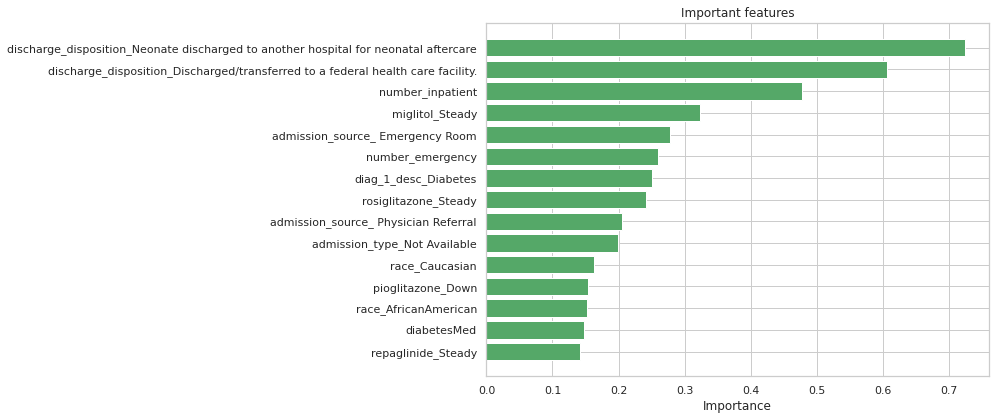

In [146]:
imp1 = imp[0:15]
plt.figure(figsize=(9, 6.5))
plt.barh(range(len(imp1))[::-1], [x[1]  for x in imp1] , align='center', color = 'g')
plt.yticks(range(len(imp1))[::-1], [x[0]  for x in imp1], )
plt.xlabel('Importance')
plt.title('Important features')
plt.show()

In [147]:
#Fit random classifier model
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, min_samples_split=5)
rf.fit(X_train, y_train)


#Get evaluation metrics on test set for random forest
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Random forest: 
train mean accuracy: 0.645872
test mean accuracy: 0.630581
[[7885  563]
 [4641  998]]
f1-score: 0.561877
Least important features (smallest coefs): 
['miglitol_No' 'admission_type_Newborn' 'admission_source_Normal Delivery'
 'discharge_disposition_Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
 'metformin-rosiglitazone_Steady' 'metformin-rosiglitazone_No'
 'miglitol_Up' 'miglitol_Steady' 'miglitol_Down' 'acarbose_Up'
 'rosiglitazone_Down' 'acetohexamide_Steady' 'acetohexamide_No'
 'nateglinide_Up' 'nateglinide_Down'
 'admission_source_ Court/Law Enforcement' 'repaglinide_Down'
 'repaglinide_Up' 'tolazamide_No' 'pioglitazone_Down']

Most important features (largest coefs): 
['number_inpatient' 'number_diagnoses' 'num_medications'
 'num_lab_procedures' 'age' 'number_outpatient' 'number_emergency'
 'time_in_hospital' 'admission_source_Transfer from a hospital'
 'num_procedures' 'diabetesMed' 'admission_source_ Emergency Room'
 'adm

In [148]:
rf = RandomForestClassifier(max_features = 'sqrt', max_samples = 0.8, class_weight = "balanced")

rf_params = {"max_depth": [5, 7, 10],
             "n_estimators": range(100, 250, 30)}

rf_cv_model = GridSearchCV(rf, rf_params, cv=2, n_jobs=-1, scoring = 'roc_auc', verbose=2).fit(X_train, y_train)
print(rf_cv_model.best_score_)
print(rf_cv_model.best_params_)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
0.6460019485395943
{'max_depth': 10, 'n_estimators': 190}


In [149]:
rf_model = rf_cv_model.best_estimator_
#rf_model.fit(data_trainn_x, data_trainn_y)
#Get evaluation metrics on test set for random forest
rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf_model.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

predicted_prob = rf_model.predict_proba(X_test)[:, 1]
predicted = rf_model.predict(X_test)
AUC_RF = roc_auc_score(y_test, predicted_prob)
print('AUC_RF = ', AUC_RF)
f1_pos = f1_score(y_test, predicted)
f1_neg = f1_score([0 if x == 1 else 1 for x in y_test], [0 if x == 1 else 1 for x in predicted])
print('F1_POS = ', f1_pos, 'F1_NEG = ', f1_neg)
HARMONIC_F1_RF = ((2 * f1_pos * f1_neg) / (f1_neg + f1_pos))
print('Harmonic_F1_RF =', HARMONIC_F1_RF)

Random forest: 
train mean accuracy: 0.648694
test mean accuracy: 0.609853
[[5241 3207]
 [2289 3350]]
f1-score: 0.613329
Least important features (smallest coefs): 
['discharge_disposition_Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
 'metformin-rosiglitazone_Steady' 'metformin-rosiglitazone_No'
 'miglitol_Up' 'miglitol_Down' 'acetohexamide_No'
 'admission_source_Normal Delivery' 'acetohexamide_Steady'
 'nateglinide_Down' 'nateglinide_Up'
 'admission_source_ Court/Law Enforcement' 'admission_type_Newborn'
 'acarbose_Up' 'tolazamide_Steady' 'repaglinide_Down' 'miglitol_No'
 'tolazamide_No' 'miglitol_Steady' 'repaglinide_Up' 'rosiglitazone_Down']

Most important features (largest coefs): 
['number_inpatient' 'number_diagnoses' 'num_lab_procedures'
 'num_medications' 'age' 'number_outpatient' 'number_emergency'
 'time_in_hospital' 'admission_source_Transfer from a hospital'
 'num_procedures' 'diabetesMed' 'admission_source_ Emergency Room'
 'adm

In [150]:
imp = []
for colName, importance in zip(np.array(X_train.columns), rf_model.feature_importances_) :
    imp.append((colName, importance))

imp = [(key, val) for key, val in sorted(imp, key = lambda x : x[1], reverse = True)]

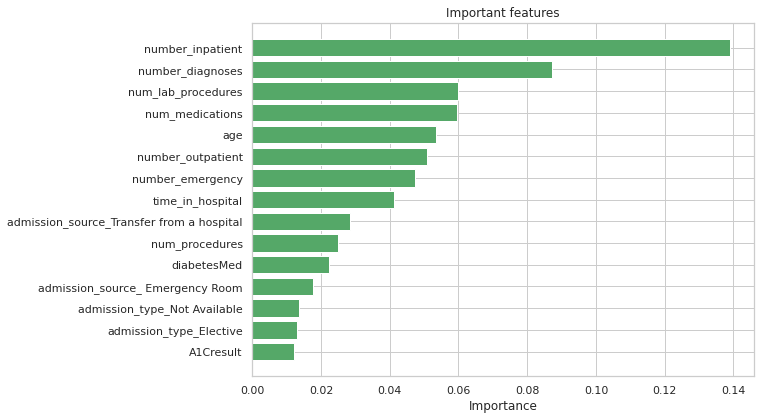

In [151]:
imp1 = imp[0:15]
plt.figure(figsize=(9, 6.5))
plt.barh(range(len(imp1))[::-1], [x[1]  for x in imp1] , align='center', color = 'g')
plt.yticks(range(len(imp1))[::-1], [x[0]  for x in imp1], )
plt.xlabel('Importance')
plt.title('Important features')
plt.show()

**Predicting early readmission (<30 as 1, >30 + No as 0)**

In [152]:
fin_df['readmitted'].value_counts()


0    41898
2    22240
1     6293
Name: readmitted, dtype: int64

In [153]:
early_readmitted_df = fin_df.copy(deep=True)
replace_early_readmitted = lambda x: 1 if x==1 else 0

early_readmitted_df['early_readmitted_or_not'] = early_readmitted_df.apply(lambda row: replace_early_readmitted(row['readmitted']), axis=1)
early_readmitted_df['early_readmitted_or_not'].value_counts()

0    64138
1     6293
Name: early_readmitted_or_not, dtype: int64

In [154]:
early_readmitted_df.drop(columns='readmitted', inplace=True)
X = early_readmitted_df.drop(columns='early_readmitted_or_not')
y = early_readmitted_df['early_readmitted_or_not']

#Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [155]:
y_train.value_counts()

0    51279
1     5065
Name: early_readmitted_or_not, dtype: int64

**Resample training set**

In [156]:
#Resample & fit model on training set

#Specify how many samples we want for <30 class and >30 class after resampling
over_strategy = {1:11590}
under_strategy = {0:29000}

#Oversample minority classes (<30, >30)
oversample = SMOTENC(categorical_features=range(0,107), sampling_strategy=over_strategy)

#Undersample majority class (No)
undersample = RandomUnderSampler(sampling_strategy=under_strategy)

steps = [('o', oversample), ('u', undersample)]
resampling = Pipeline(steps=steps)

X_train_res, y_train_res = resampling.fit_resample(X_train, y_train)

In [157]:
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
X_train_res

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,metformin_Down,metformin_No,metformin_Steady,...,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed
0,0,0,1,0,0,1,0,0,1,0,...,2,14,0,1,0,7,0,0,-1,1
1,0,0,1,0,0,1,0,0,1,0,...,0,5,0,0,0,4,0,0,1,1
2,0,0,1,0,0,1,0,0,1,0,...,1,21,4,0,0,9,0,0,-1,1
3,0,0,1,0,0,0,1,0,0,1,...,4,12,0,0,0,9,0,0,1,1
4,0,0,1,0,0,0,1,0,0,1,...,2,27,0,0,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40585,0,0,1,0,0,0,1,0,1,0,...,2,10,0,0,1,9,0,0,-1,-1
40586,0,0,1,0,0,0,1,0,1,0,...,0,9,0,0,0,9,0,0,-1,1
40587,0,0,1,0,0,0,1,0,1,0,...,0,11,0,0,0,9,0,0,-1,1
40588,0,0,1,0,0,0,1,0,1,0,...,0,12,0,0,0,9,0,0,-1,1


**Fit classification models on training set & evaluate on test set**

**Logistic regression**

In [158]:
#Fit logistic regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_res, y_train_res)

#Get final evaluation metrics on test set for logistic regression
lr_train_score = lr.score(X_train_res, y_train_res)
lr_test_score = lr.score(X_test, y_test)
print("Logistic regression: ")
print("train mean accuracy: %f" %(lr_train_score))
print("test mean accuracy: %f" %(lr_test_score))

#Get confusion matrix and f1-score
y_pred = lr.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))


predicted_prob = lr.predict_proba(X_test)[:, 1]
predicted = lr.predict(X_test)
AUC_LR = roc_auc_score(y_test, predicted_prob)
print('AUC_LR = ', AUC_LR)
f1_pos = f1_score(y_test, predicted)
f1_neg = f1_score([0 if x == 1 else 1 for x in y_test], [0 if x == 1 else 1 for x in predicted])
print('F1_POS = ', f1_pos, 'F1_NEG = ', f1_neg)
HARMONIC_F1_LR = ((2 * f1_pos * f1_neg) / (f1_neg + f1_pos))
print('HARMONIC_F1_LR = ', HARMONIC_F1_LR)



#Get feature names
features = np.array(X_train_res.columns)
#Sort coefficients in ascending order
sorted_coeff_index = lr.coef_[0].argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Logistic regression: 
train mean accuracy: 0.807194
test mean accuracy: 0.906013
[[12730   129]
 [ 1195    33]]
f1-score: 0.871843
AUC_LR =  0.5977201863458665
F1_POS =  0.04748201438848921 F1_NEG =  0.9505675029868579
HARMONIC_F1_LR =  0.09044613331961143
Least important features (smallest coefs): 
['diag_1_desc_Respiratory' 'diag_1_desc_Genitourinary'
 'diag_2_desc_Genitourinary' 'diag_3_desc_Genitourinary'
 'diag_3_desc_Musculoskeletal' 'diag_2_desc_Musculoskeletal'
 'diag_3_desc_Respiratory' 'diag_1_desc_Musculoskeletal'
 'diag_3_desc_Injury' 'diag_1_desc_Injury' 'diag_2_desc_Respiratory'
 'diag_2_desc_Injury' 'diag_1_desc_Neoplasms' 'diag_1_desc_Digestive'
 'diag_3_desc_Digestive' 'diag_1_desc_Other' 'diag_3_desc_Other'
 'diag_3_desc_Neoplasms' 'diag_2_desc_Digestive' 'diag_3_desc_Circulatory']

Most important features (largest coefs): 
['metformin-rosiglitazone_No' 'acetohexamide_No' 'tolazamide_No'
 'nateglinide_No'
 'discharge_disposition_Discharged/transferred to a federal hea

In [159]:
from sklearn.linear_model import SGDClassifier
for C in np.linspace(0.0001, 0.03, 30) :
    lr_model = SGDClassifier(alpha = C, learning_rate = 'adaptive', loss = 'log' , penalty = 'elasticnet', \
                             random_state = 24, class_weight = 'balanced', eta0 = 0.001,
                             early_stopping = True, n_iter_no_change = 3
                              )
    lr_model.fit(X_train_res, y_train_res)
    print(C, roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))
lr_model.fit(X_train_res, y_train_res)
predicted_prob = lr_model.predict_proba(X_test)[:, 1]
predicted = lr_model.predict(X_test)
AUC_LR = roc_auc_score(y_test, predicted_prob)
print('AUC_LR = ', AUC_LR)
f1_pos = f1_score(y_test, predicted)
f1_neg = f1_score([0 if x == 1 else 1 for x in y_test], [0 if x == 1 else 1 for x in predicted])
print('F1_POS = ', f1_pos, 'F1_NEG = ', f1_neg)
HARMONIC_F1_LR = ((2 * f1_pos * f1_neg) / (f1_neg + f1_pos))
print('HARMONIC_F1_LR = ', HARMONIC_F1_LR)

0.0001 0.5906728148677476
0.0011310344827586208 0.588857586658402
0.0021620689655172413 0.5881987241727046
0.0031931034482758623 0.5872277189349884
0.004224137931034483 0.5866181254817663
0.005255172413793104 0.586174197567047
0.006286206896551725 0.585669411631494
0.007317241379310346 0.5850676074983161
0.008348275862068965 0.5844818886276688
0.009379310344827587 0.5837384201941732
0.010410344827586206 0.5829008466420937
0.011441379310344828 0.5821662441013316
0.01247241379310345 0.5811008171060054
0.013503448275862069 0.5803736872462613
0.01453448275862069 0.5796397179835515
0.01556551724137931 0.5789375392790712
0.01659655172413793 0.5781941975011862
0.017627586206896553 0.5775725717649687
0.018658620689655174 0.5768843885054461
0.019689655172413792 0.5762107706411281
0.020720689655172413 0.5755243605601522
0.021751724137931035 0.5748466897162992
0.022782758620689656 0.5730566659734383
0.023813793103448277 0.57242281797081
0.0248448275862069 0.5718078416541426
0.025875862068965517 0

In [160]:
lr_model = SGDClassifier(alpha = 0.02896896551724138, learning_rate = 'adaptive', loss = 'log' , penalty = 'elasticnet', \
                             random_state = 24, class_weight = 'balanced', eta0 = 0.001,
                             early_stopping = True, n_iter_no_change = 3
                              )
lr_model.fit(X_train_res, y_train_res)
predicted_prob = lr_model.predict_proba(X_test)[:, 1]
predicted = lr_model.predict(X_test)
AUC_LR = roc_auc_score(y_test, predicted_prob)
print('AUC_LR = ', AUC_LR)
f1_pos = f1_score(y_test, predicted)
f1_neg = f1_score([0 if x == 1 else 1 for x in y_test], [0 if x == 1 else 1 for x in predicted])
print('F1_POS = ', f1_pos, 'F1_NEG = ', f1_neg)
HARMONIC_F1_LR = ((2 * f1_pos * f1_neg) / (f1_neg + f1_pos))
print('HARMONIC_F1_LR = ', HARMONIC_F1_LR)

AUC_LR =  0.5696029574591668
F1_POS =  0.17357868717385333 F1_NEG =  0.7119471568064331
HARMONIC_F1_LR =  0.2791084046969255


In [161]:
imp = []
for colName, importance in zip(np.array(X_train.columns), lr.coef_[0]) :
    imp.append((colName, importance))

imp = [(key, val) for key, val in sorted(imp, key = lambda x : x[1], reverse = True)]

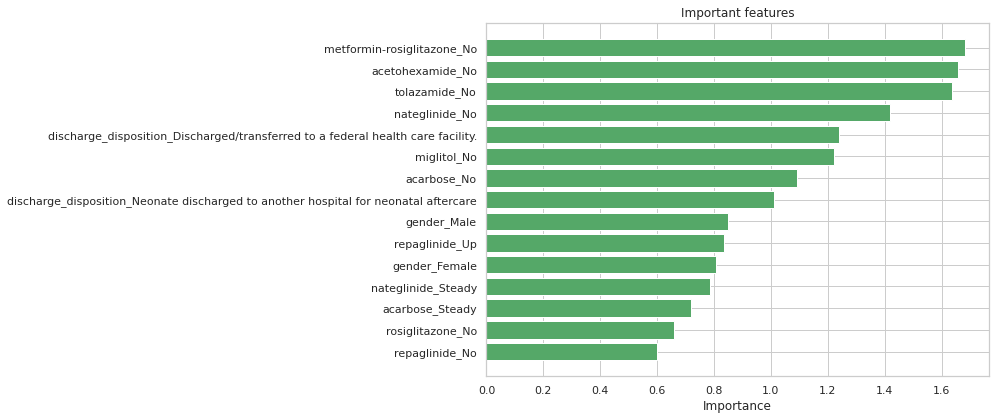

In [162]:
imp1 = imp[0:15]
plt.figure(figsize=(9, 6.5))
plt.barh(range(len(imp1))[::-1], [x[1]  for x in imp1] , align='center', color = 'g')
plt.yticks(range(len(imp1))[::-1], [x[0]  for x in imp1], )
plt.xlabel('Importance')
plt.title('Important features')
plt.show()

In [163]:
#Fit random classifier model
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, min_samples_split=5)
rf.fit(X_train_res, y_train_res)


#Get evaluation metrics on test set for random forest
rf_train_score = rf.score(X_train_res, y_train_res)
rf_test_score = rf.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

Random forest: 
train mean accuracy: 0.734910
test mean accuracy: 0.907290
[[12757   102]
 [ 1204    24]]
f1-score: 0.871468
Least important features (smallest coefs): 
['metformin-rosiglitazone_Steady' 'rosiglitazone_Down'
 'acetohexamide_Steady' 'acetohexamide_No' 'nateglinide_Up'
 'nateglinide_Down' 'repaglinide_Up' 'acarbose_Up' 'miglitol_Down'
 'pioglitazone_Down' 'repaglinide_Down' 'miglitol_Steady'
 'admission_source_Normal Delivery' 'miglitol_Up' 'tolazamide_No'
 'discharge_disposition_Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
 'tolazamide_Steady' 'admission_source_ Court/Law Enforcement'
 'admission_type_Newborn' 'miglitol_No']

Most important features (largest coefs): 
['number_diagnoses'
 'discharge_disposition_Discharged/transferred to another short term hospital'
 'age' 'num_procedures' 'A1Cresult'
 'discharge_disposition_Discharged to home' 'num_medications'
 'number_outpatient' 'num_lab_procedures' 'time_in_hospital'
 'diag_

In [164]:
rf = RandomForestClassifier(max_features = 'sqrt', max_samples = 0.8, class_weight = "balanced")

rf_params = {"max_depth": [5, 7, 10, 15],
"n_estimators": range(100, 250, 30)}

rf_cv_model = GridSearchCV(rf, rf_params, cv=2, n_jobs=-1, scoring = 'roc_auc', verbose=2).fit(X_train_res, y_train_res)                                                                                              
print(rf_cv_model.best_score_)
print(rf_cv_model.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
0.7046765523191811
{'max_depth': 15, 'n_estimators': 160}


In [165]:
rf_model = rf_cv_model.best_estimator_
#rf_model.fit(data_trainn_x, data_trainn_y)
#Get evaluation metrics on test set for random forest
rf_train_score = rf_model.score(X_train_res, y_train_res)
rf_test_score = rf_model.score(X_test, y_test)
print("Random forest: ")
print("train mean accuracy: %f" %(rf_train_score))
print("test mean accuracy: %f" %(rf_test_score))

#Get confusion matrix and f1-score
y_pred = rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(confusion_matrix(y_test, y_pred))
print("f1-score: %f" %(f1))

#Get feature names
features = np.array(X_train.columns)
#Sort coefficients in ascending order
sorted_coeff_index = rf_model.feature_importances_.argsort()

#Get features with top 20 smallest and top 20 largest coefficients
print('Least important features (smallest coefs): \n{}\n'.format(features[sorted_coeff_index[:20]]))
print('Most important features (largest coefs): \n{}\n'.format(features[sorted_coeff_index[:-21:-1]]))

predicted_prob = rf_model.predict_proba(X_test)[:, 1]
predicted = rf_model.predict(X_test)
AUC_RF = roc_auc_score(y_test, predicted_prob)
print('AUC_RF = ', AUC_RF)
f1_pos = f1_score(y_test, predicted)
f1_neg = f1_score([0 if x == 1 else 1 for x in y_test], [0 if x == 1 else 1 for x in predicted])
print('F1_POS = ', f1_pos, 'F1_NEG = ', f1_neg)
HARMONIC_F1_RF = ((2 * f1_pos * f1_neg) / (f1_neg + f1_pos))
print('Harmonic_F1_RF =', HARMONIC_F1_RF)

Random forest: 
train mean accuracy: 0.836659
test mean accuracy: 0.759282
[[10340  2519]
 [  872   356]]
f1-score: 0.799360
Least important features (smallest coefs): 
['acetohexamide_Steady' 'acetohexamide_No'
 'admission_source_Normal Delivery' 'miglitol_Down'
 'metformin-rosiglitazone_No' 'acarbose_Up'
 'metformin-rosiglitazone_Steady'
 'discharge_disposition_Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere'
 'miglitol_Up' 'nateglinide_Down' 'admission_type_Newborn' 'tolazamide_No'
 'tolazamide_Steady' 'nateglinide_Up' 'miglitol_No'
 'admission_source_ Court/Law Enforcement' 'repaglinide_Down'
 'miglitol_Steady' 'rosiglitazone_Down' 'pioglitazone_Down']

Most important features (largest coefs): 
['number_diagnoses' 'age' 'num_medications' 'num_lab_procedures'
 'num_procedures' 'A1Cresult' 'time_in_hospital'
 'discharge_disposition_Discharged/transferred to another short term hospital'
 'number_outpatient' 'discharge_disposition_Discharged to h

In [166]:
imp = []
for colName, importance in zip(np.array(X_train.columns), rf_model.feature_importances_) :
    imp.append((colName, importance))

imp = [(key, val) for key, val in sorted(imp, key = lambda x : x[1], reverse = True)]


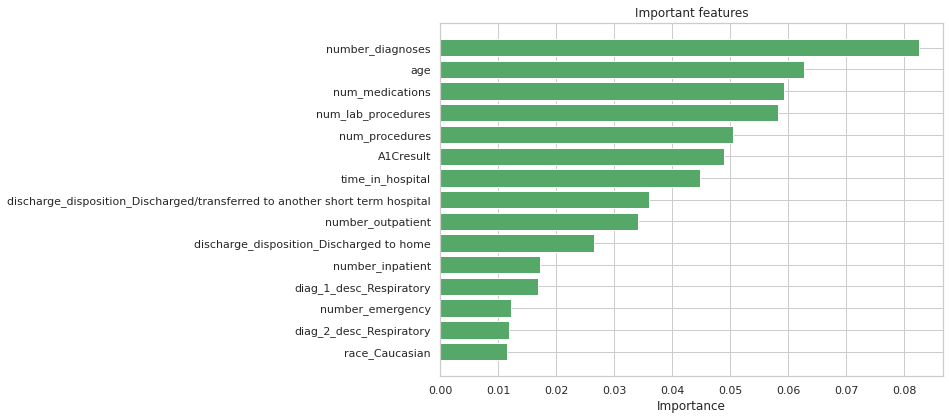

In [167]:
imp1 = imp[0:15]
plt.figure(figsize=(9, 6.5))
plt.barh(range(len(imp1))[::-1], [x[1]  for x in imp1] , align='center', color = 'g')
plt.yticks(range(len(imp1))[::-1], [x[0]  for x in imp1], )
plt.xlabel('Importance')
plt.title('Important features')
plt.show()

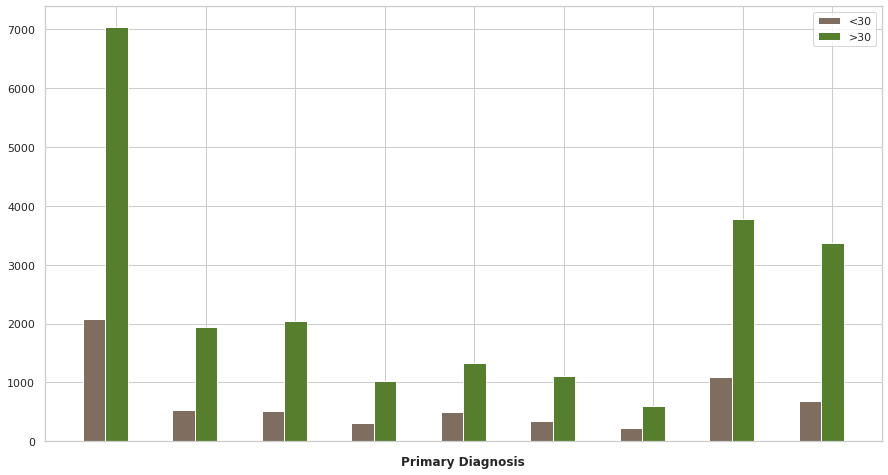

In [168]:
# Plot Readmission vs Primary Diagnosis
data1 = data[['number_diagnoses','readmitted']]
data1

fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = data_diag_cnt1
bars2 = data_diag_cnt2
bars3 = data_diag_cnt3
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='<30')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='>30')
#plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='NO')
 
# Add xticks on the middle of the group bars
plt.xlabel('Primary Diagnosis', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [169]:
data2 = early_readmitted_df.copy() 

In [173]:
data2['num_medications']

0         1
1        18
2        13
3        16
4         8
         ..
70426    33
70427    26
70428    17
70429    22
70430     3
Name: num_medications, Length: 70431, dtype: int64

Text(0.5, 1.0, 'Not Readmitted Patient')

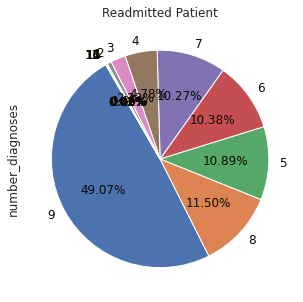

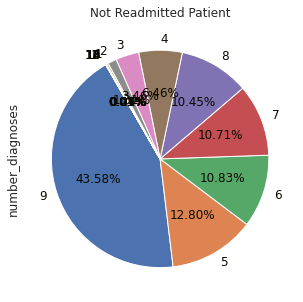

In [170]:
fig = plt.figure(figsize = (10, 5)) 
#a = sns.countplot(x = 'number_diagnoses', hue = 'early_readmitted_or_not', data = data2)


ax = data2[data2.early_readmitted_or_not == 1].number_diagnoses.value_counts().plot.pie(autopct="%.2f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Readmitted Patient')
fig = plt.figure(figsize = (10, 5)) 


ax = data2[data2.early_readmitted_or_not == 0].number_diagnoses.value_counts().plot.pie(autopct="%0.2f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Not Readmitted Patient')

Text(0.5, 1.0, 'Not Readmitted Patient')

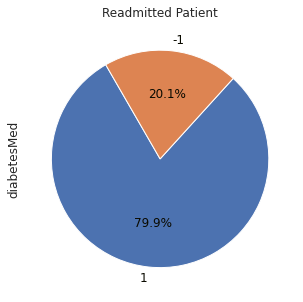

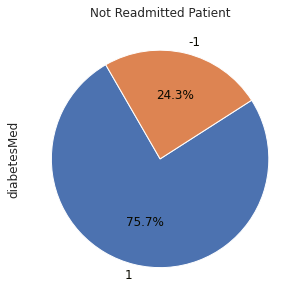

In [174]:
fig = plt.figure(figsize = (10, 5)) 
#a = sns.countplot(x = 'number_diagnoses', hue = 'readmitted', data = data2)


ax = data2[data2.early_readmitted_or_not == 1].diabetesMed.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Readmitted Patient')
fig = plt.figure(figsize = (10, 5)) 


ax = data2[data2.early_readmitted_or_not == 0].diabetesMed.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Not Readmitted Patient')

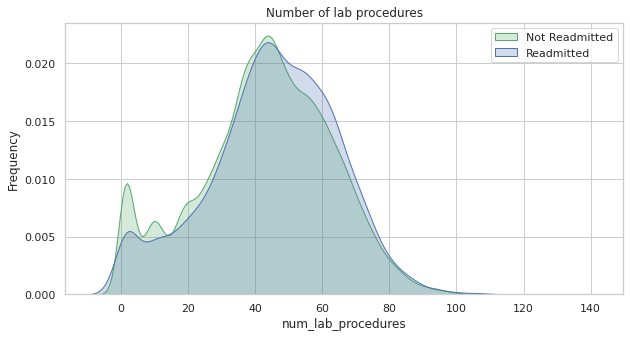

In [176]:
fig = plt.figure(figsize = (10, 5)) 
a = sns.kdeplot(data2.loc[(data2['early_readmitted_or_not'] == 0), "num_lab_procedures"] ,
                 color = "g", shade = True, label = "Not Readmitted")

a = sns.kdeplot(data2.loc[(data2['early_readmitted_or_not'] == 1), "num_lab_procedures"] ,
                 color = "b", shade = True, label = "Readmitted")

a.legend()
a.set_xlabel("num_lab_procedures")
a.set_ylabel("Frequency")
a.set_title("Number of lab procedures")
plt.show()

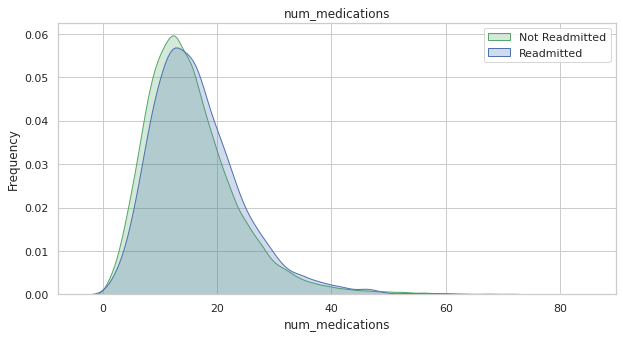

In [178]:
fig = plt.figure(figsize = (10, 5)) 
a = sns.kdeplot(data2.loc[(data2['early_readmitted_or_not'] == 0), "num_medications"] ,
                 color = "g", shade = True, label = "Not Readmitted")

a = sns.kdeplot(data2.loc[(data2['early_readmitted_or_not'] == 1), "num_medications"] ,
                 color = "b", shade = True, label = "Readmitted")

a.legend()
a.set_xlabel("num_medications")
a.set_ylabel("Frequency")
a.set_title("num_medications")
plt.show()

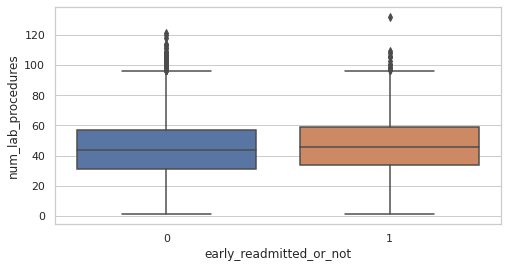

In [179]:
fig = plt.figure(figsize = (8, 4))
sns.boxplot(x = 'early_readmitted_or_not', y = 'num_lab_procedures', data = data2)

In [181]:
print(data2[data2.early_readmitted_or_not == 1].age.value_counts())

75    1824
65    1414
85    1201
55     879
45     507
35     188
95     168
25      83
15      26
5        3
Name: age, dtype: int64


Text(0.5, 1.0, 'Not Readmitted Patient')

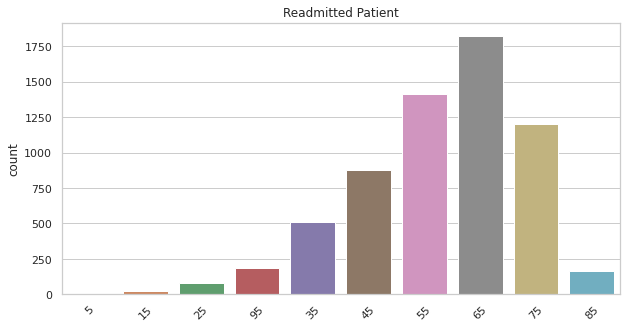

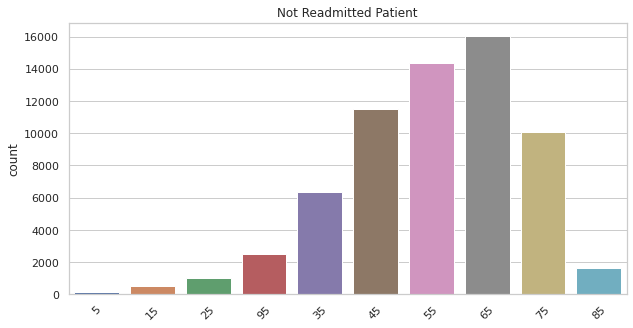

In [182]:
fig = plt.figure(figsize = (10, 5)) 
ax = fig.add_subplot(111)

sns.countplot(data2[data2.early_readmitted_or_not == 1].age.values)
ax.set_xticklabels(['5', '15', '25', '95', '35', '45', '55', '65', '75', '85'], rotation = 45)
ax.set_title('Readmitted Patient')

fig = plt.figure(figsize = (10, 5)) 
ax = fig.add_subplot(111)
sns.countplot(data2[data2.early_readmitted_or_not == 0].age.values)
ax.set_xticklabels(['5', '15', '25', '95', '35', '45', '55', '65', '75', '85'], rotation = 45)
ax.set_title('Not Readmitted Patient')

In [183]:
print(data2[data2.early_readmitted_or_not == 1].A1Cresult.value_counts())

0    5213
8     510
5     324
7     246
Name: A1Cresult, dtype: int64


Text(0.5, 1.0, 'Not Readmitted Patient')

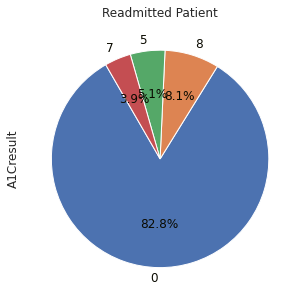

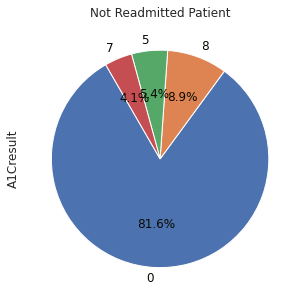

In [184]:
fig = plt.figure(figsize = (10, 5)) 
#a = sns.countplot(x = 'number_diagnoses', hue = 'readmitted', data = data2)


ax = data2[data2.early_readmitted_or_not == 1].A1Cresult.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Readmitted Patient')
fig = plt.figure(figsize = (10, 5)) 


ax = data2[data2.early_readmitted_or_not == 0].A1Cresult.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Not Readmitted Patient')

In [189]:
print(data2[data2.early_readmitted_or_not == 0].insulin_No.value_counts())

0    32524
1    31614
Name: insulin_No, dtype: int64


Text(0.5, 1.0, 'Not Readmitted Patient')

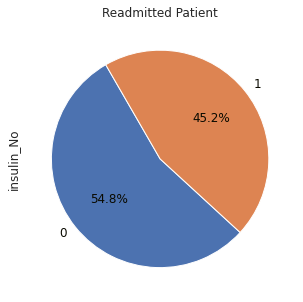

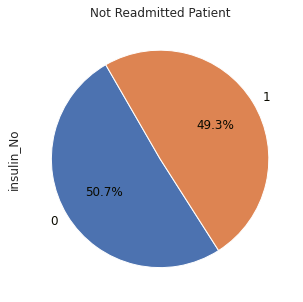

In [190]:
fig = plt.figure(figsize = (10, 5)) 
#a = sns.countplot(x = 'number_diagnoses', hue = 'readmitted', data = data2)


ax = data2[data2.early_readmitted_or_not == 1].insulin_No.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Readmitted Patient')
fig = plt.figure(figsize = (10, 5)) 


ax = data2[data2.early_readmitted_or_not == 0].insulin_No.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Not Readmitted Patient')